/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


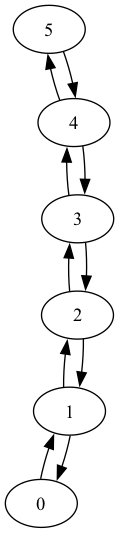

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

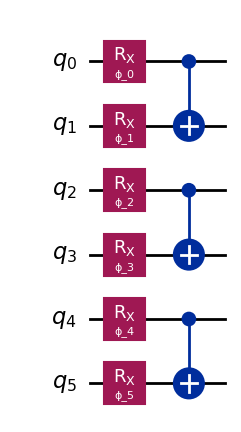

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


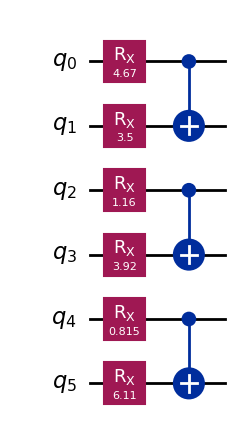

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

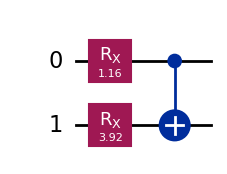

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

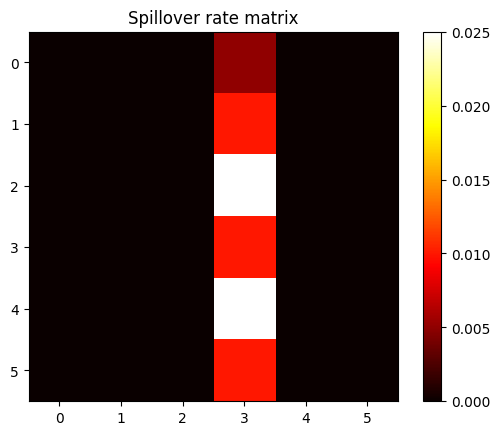

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 3] = 0.01  # γ_2->3
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
# gamma_matrix[0, 2] = 0.005  # γ_0->2
# gamma_matrix[1, 2] = 0.01  # γ_1->2
# gamma_matrix[3, 2] = 0.025  # γ_3->2
# gamma_matrix[4, 2] = 0.025  # γ_4->2
# gamma_matrix[5, 2] = 0.01  # γ_5->2
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ]])

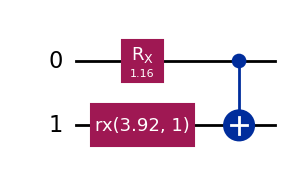

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '4b3fbb6b98b746a99bf2109bda5c24e0',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15ca7c750>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '4b3fbb6b98b746a99bf2109bda5c24e0',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


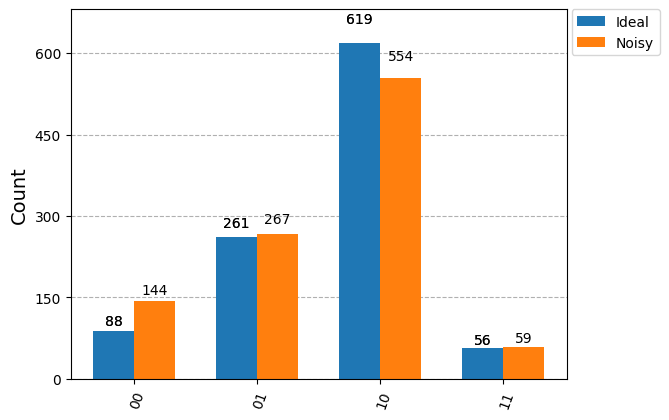

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9913759632466694

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -0.5 * np.pi,
        0.5 * np.pi,
        q_reg[0],
    )
    my_qc.u(
        0,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.3, high=0.3, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit
import itertools

class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters
        self.num_qubits = len(applied_qubits)  # Number of qubits

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        # Define discrete observation values for a single qubit
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        # Generate all possible combinations for N qubits
        self.discrete_obs_vals_raw = np.array(
            list(itertools.product(self.single_qubit_discrete_obs_vals_raw, repeat=self.num_qubits))
        )
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")

        # Initialize reward history and probability weights for all possible combinations
        self.discrete_reward_history = np.ones(
            (discrete_history_length, len(self.discrete_obs_vals_raw))
        )
        self.prob_weights = np.ones(len(self.discrete_obs_vals_raw))
        self.prob_weights /= len(self.prob_weights)

        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale
        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        """
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        elif self.circuit_param_distribution == "simple_discrete":
            # Sample each qubit's observation independently
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
        elif self.circuit_param_distribution == "moving_discrete":
            # Update probability weights based on reward history
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            # Sample an index from all possible combinations
            idx = np.random.choice(
                len(self.discrete_obs_vals_raw),
                p=self.prob_weights,
            )
            obs_raw = self.discrete_obs_vals_raw[idx]
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        print(f"batch action shape: {action.shape}")
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        # Find the index of the closest discrete observation value
        obs_ind = np.argmin(np.sum((self.discrete_obs_vals_raw - obs) ** 2, axis=1))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        """
        return self.obs_raw

    def _get_info(self) -> Any:
        return {}

In [23]:
# Constructing general angle spillover env

# from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)
rescaled_g_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [24]:
rescaled_g_env.unwrapped.batch_size

32

In [25]:
print(rescaled_g_env.unwrapped.discrete_obs_vals_raw)

[[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]


In [26]:
obs, _ = rescaled_g_env.unwrapped.reset(
    debug_obs=rescaled_g_env.unwrapped.obs_raw_to_angles(np.array([1., 1., 1., 1., 1., 1.]))
)

Sampled angles:  [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
Environment Observation: [1. 1. 1. 1. 1. 1.]


In [27]:
print(general_env.observation_space.shape[0])

6


In [28]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.005 0.01  0.025 0.01  0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [29]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
print(computed_spillover_angles)
subsystem_spillover_angles = computed_spillover_angles[2:4]
print(subsystem_spillover_angles)
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [2, 3]] = -subsystem_spillover_angles

[0.         0.         0.         0.26703538 0.         0.        ]
[0.         0.26703538]


In [30]:
opt_action

array([[ 0.        ,  0.        , -0.        , -0.26703538,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999998 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999993 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999989 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999984 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999979 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity 

Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.999999999999997 Std: 0.0
Number of repetitions: 15
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999967 Std: 0.0
Number of repetitions: 17
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999962 Std: 0.0
Number of repetitions: 19
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9999999999999998
Reward (avg): 0.9999999999999958 Std: 0.0
Found parameters: [0.00055789 0.00055789], in radians: [0.00018 0.00018]


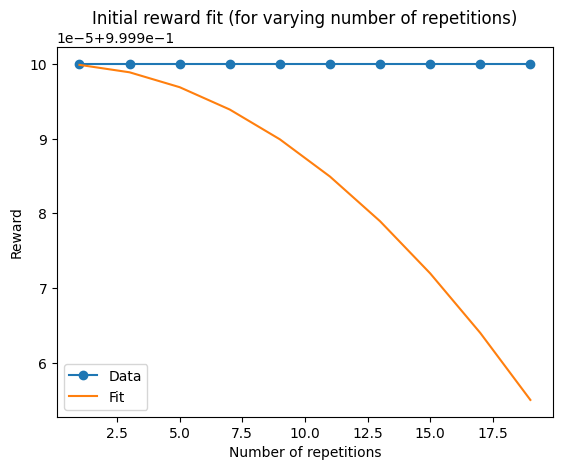

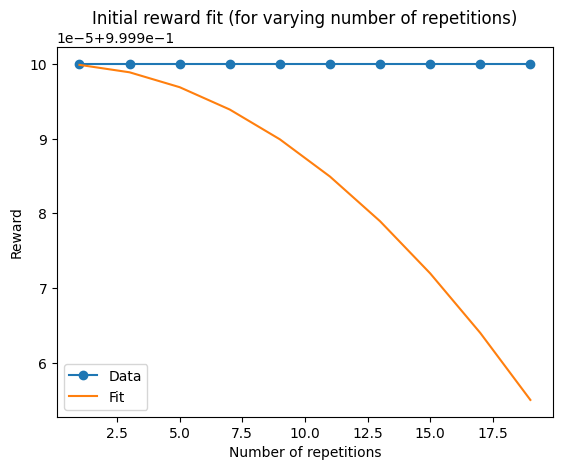

In [31]:
general_env.initial_reward_fit(
    # np.zeros((1, 7)),
    opt_action,
    ExecutionConfig(
        sampling_paulis=100,
        n_shots=10,
        n_reps=list(
            range(1, 20, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    # fit_p0=list(subsystem_spillover_angles)
)

In [32]:
general_env.batch_size

32

## Running Training for One Spillover Qubit, Fidelity Access, with Random Uniform Sampling

In [36]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [37]:
train_env.batch_size

32

In [38]:
rescaled_q_env.unwrapped.batch_size

32

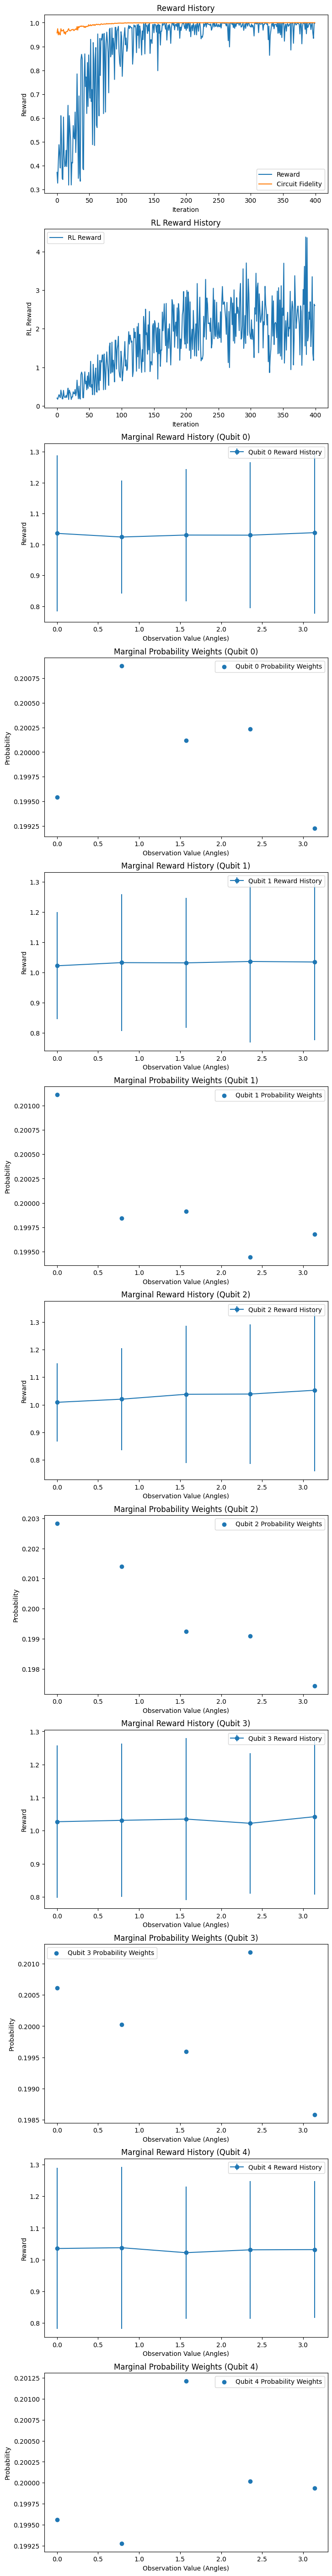

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1751538417/Test PPO CleanRL.cleanrl_model


In [39]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [40]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         2.35619449 0.        ]
Environment Observation: [ 0.5  0.  -0.5  0.5 -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999229774941909
Reward (avg): 0.994422224678015 Std: 0.0004993701625720129
obs: [ 0.5  0.  -0.5  0.5 -1. ]
reward: [2.23839511 2.28266905 2.24252218 2.25088854 2.2441317  2.26800513
 2.35213876 2.22638591 2.22440471 2.2840116  2.27545176 2.25740304
 2.24889753 2.26240852 2.23559816 2.2283954  2.27222888 2.24215862
 2.31314923 2.28400951 2.23089486 2.26418684 2.20689734 2.19155464
 2.22218598 2.30475752 2.21227033 2.16957881 2.34241131 2.22638735
 2.2977281  2.26795352]
Sampled angles:  [3.14159265 1.57079633 0.78539816 0.         1.57079633 0.        ]
Environment Observation: [ 1.   0.  -0.5  0.  -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998611255344334
Reward (avg): 0.9879424785429578 Std: 0.0006121248902074411
obs: [ 1.   0.  -0.5  0.  -1. ]
reward: [1.87845564 1.92911278 1.92037794 1.90378591 1.92291567 1.9326499
 1.92793372 1.91584    1.91352313 1.9374164  1.8851751  1.93194282
 1.86644509 1.915659   1.90610061 1.89990427 1.92701521 1.94247462
 1.91878917 1.96054808 1.92144332 1.91327052 1.92715892 1.87899557
 1.90302774 1.91268221 1.92267993 1.93098616 1.93519095 1.97102231
 1.94350485 1.92143906]
Sampled angles:  [0.         1.57079633 0.78539816 0.         0.78539816 3.14159265]
Environment Observation: [-1.   0.  -0.5 -0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999756918653977
Reward (avg): 0.9778009609241256 Std: 0.0012035237476657288
obs: [-1.   0.  -0.5 -0.5  1. ]
reward: [1.64791412 1.63324335 1.62501583 1.65385711 1.65080903 1.63982408
 1.62038862 1.69083874 1.6508133  1.64691218 1.63634317 1.66336716
 1.63164076 1.7209061  1.63212524 1.64064274 1.65579003 1.69174659
 1.68464941 1.67456477 1.66307709 1.63484759 1.65496026 1.65919181
 1.62060031 1.64921213 1.67688327 1.62759087 1.64605801 1.66582547
 1.64380564 1.70495233]
Sampled angles:  [1.57079633 0.         0.         0.         3.14159265 3.14159265]
Environment Observation: [ 0. -1. -1.  1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999752667646076
Reward (avg): 0.9766411429710584 Std: 0.0022921150403991046
obs: [ 0. -1. -1.  1.  1.]
reward: [1.58018122 1.66374672 1.60023053 1.69637965 1.59130575 1.6324246
 1.64397497 1.69020124 1.70239077 1.61019381 1.56729884 1.63978243
 1.61567852 1.68154759 1.57971241 1.71700225 1.64619155 1.55067056
 1.64994051 1.66051244 1.60234414 1.6377167  1.63392721 1.60940472
 1.62797272 1.60744901 1.65611195 1.6566309  1.64243014 1.65079903
 1.54944093 1.6821624 ]
Sampled angles:  [2.35619449 1.57079633 2.35619449 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.   0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999020071963942
Reward (avg): 0.9927698577075041 Std: 0.00040680463919437395
obs: [ 0.5  0.   0.5 -1.   0.5]
reward: [2.15643225 2.15013628 2.08934901 2.09901475 2.10701863 2.08990994
 2.16411764 2.2018287  2.15479735 2.1562672  2.15831721 2.1344501
 2.1442767  2.13963021 2.15373103 2.13633982 2.15612594 2.14754614
 2.16232352 2.15516875 2.14416041 2.13385526 2.12466799 2.12809385
 2.12970623 2.13532088 2.16563562 2.15865945 2.11603115 2.17707693
 2.14379397 2.11526733]
Sampled angles:  [2.35619449 3.14159265 0.78539816 0.         1.57079633 2.35619449]
Environment Observation: [ 0.5  1.  -0.5  0.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999658555296931
Reward (avg): 0.9994914410635505 Std: 0.0002460749694397472
obs: [ 0.5  1.  -0.5  0.   0.5]
reward: [3.33638679 3.47616496 2.87833958 3.43853264 3.25040903 3.11690291
 3.46169049 3.39536984 4.00792492 3.33575731 3.39406883 3.2376141
 3.22667411 3.37675835 3.24754785 3.16150572 3.11785793 3.6518227
 3.6696768  3.36726175 3.39877921 3.14076371 3.65257847 3.01501497
 3.24716811 3.03006308 3.51109121 3.5339189  3.26976156 3.4067309
 3.30990101 3.34783532]
Sampled angles:  [0.         2.35619449 0.         0.         0.78539816 2.35619449]
Environment Observation: [-1.   0.5 -1.  -0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996864209505664
Reward (avg): 0.9697309687142882 Std: 0.0007610694687054052
obs: [-1.   0.5 -1.  -0.5  0.5]
reward: [1.52383043 1.52019902 1.5196346  1.51706327 1.51434524 1.5157775
 1.52168079 1.53922177 1.49032016 1.52758298 1.51298977 1.51926737
 1.50782851 1.52129227 1.4925208  1.51829292 1.51037465 1.50705994
 1.53260961 1.51564876 1.52205831 1.53817344 1.51202877 1.52365048
 1.52793155 1.51731955 1.52448724 1.5328358  1.52257127 1.5066567
 1.52865138 1.52848706]
Sampled angles:  [0.78539816 2.35619449 3.14159265 0.         0.         3.14159265]
Environment Observation: [-0.5  0.5  1.  -1.   1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999503624843361
Reward (avg): 0.9998075506104069 Std: 0.00010471296805030563
obs: [-0.5  0.5  1.  -1.   1. ]
reward: [3.76563635 4.10573394 3.6962297  3.9251048  3.84582874 3.9767373
 3.66992022 4.16752756 3.91532067 3.73860379 4.01956631 3.98845737
 3.87466929 3.75160969 3.41603111 3.58969662 3.85271932 4.12051051
 3.81632317 3.25325559 3.70651957 3.48520211 3.87743687 3.68489289
 3.68730724 3.86449641 3.61115578 3.48012499 3.48825433 3.50497828
 3.85625043 3.92087228]
Sampled angles:  [2.35619449 2.35619449 2.35619449 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.5  0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999518846498356
Reward (avg): 0.9979212642104857 Std: 0.00027252798660523024
obs: [ 0.5  0.5  0.5 -1.   0.5]
reward: [2.77686681 2.70210995 2.72275876 2.65994826 2.62712265 2.60372543
 2.70724474 2.75501359 2.66506861 2.72262716 2.54899484 2.78944854
 2.65484699 2.61754951 2.73059764 2.80879785 2.74250205 2.68693252
 2.74263294 2.61690437 2.68758785 2.6612933  2.7101712  2.7181454
 2.63427191 2.68476332 2.66136237 2.65968104 2.63871187 2.70959898
 2.63064131 2.67138513]
Sampled angles:  [3.14159265 3.14159265 3.14159265 0.         0.         0.78539816]
Environment Observation: [ 1.   1.   1.  -1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999957572139902
Reward (avg): 0.9988348249869305 Std: 0.00018099297424777324
obs: [ 1.   1.   1.  -1.  -0.5]
reward: [3.01745836 2.89416648 2.82819964 3.02928487 3.03843315 2.92100761
 3.05992469 3.04987405 2.93373966 3.05427747 2.85095061 2.93498862
 2.87903738 2.87222291 2.85190683 2.89232751 2.93226246 2.86953879
 2.91898342 2.9019052  2.80924763 2.91647792 2.96130981 2.95699269
 3.00272467 3.01028271 2.98166542 2.90666238 2.95773269 2.86925098
 2.96968188 2.97273099]
Sampled angles:  [0.78539816 1.57079633 0.78539816 0.         0.78539816 1.57079633]
Environment Observation: [-0.5  0.  -0.5 -0.5  0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.99972296624906
Reward (avg): 0.9741299685544174 Std: 0.0011315872808365156
obs: [-0.5  0.  -0.5 -0.5  0. ]
reward: [1.58933179 1.60089742 1.58989724 1.59209104 1.58565951 1.58521011
 1.62217927 1.54975466 1.61378469 1.59217758 1.60620187 1.62352553
 1.57884992 1.60589283 1.57674726 1.5821203  1.58464351 1.55179682
 1.59113001 1.57601138 1.62052581 1.56019657 1.56966736 1.57672738
 1.56528767 1.61121274 1.60464186 1.5776713  1.59749687 1.57456805
 1.56881052 1.57911648]
Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         3.14159265 0.78539816]
Environment Observation: [ 0.5  0.  -0.5  1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999413299575826
Reward (avg): 0.9988164193127457 Std: 0.0002562246033686374
obs: [ 0.5  0.  -0.5  1.  -0.5]
reward: [2.9165414  2.90979049 2.80725624 2.90700016 2.9272433  3.16272406
 2.88757914 3.05742398 2.80740589 2.85398395 2.81003182 2.97643624
 2.90195766 2.91964606 2.93621761 2.91629791 2.76333751 2.82676903
 2.92954708 2.86133888 2.9223406  2.87655296 2.86884064 3.03148774
 2.99780956 3.00711274 3.1552787  2.88305139 3.0465432  3.12031816
 2.93576252 3.0881318 ]
Sampled angles:  [3.14159265 1.57079633 0.         0.         2.35619449 3.14159265]
Environment Observation: [ 1.   0.  -1.   0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998808347037345
Reward (avg): 0.9890213949713889 Std: 0.002175204498302853
obs: [ 1.   0.  -1.   0.5  1. ]
reward: [2.01211115 1.94307512 1.97729985 1.92899486 1.90876923 1.98372559
 1.85194159 1.97337859 1.72245889 1.99680039 1.94722502 2.06795865
 2.07932141 1.9296971  2.10241231 1.84793373 1.96652117 1.97691354
 1.99348491 1.8489678  2.12462859 1.90090665 2.02029853 1.94774923
 1.9232553  1.98453919 1.93279743 1.99801184 1.95862052 2.01850046
 2.05211406 2.02666617]
Sampled angles:  [2.35619449 0.         0.78539816 0.         2.35619449 0.        ]
Environment Observation: [ 0.5 -1.  -0.5  0.5 -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997379841276441
Reward (avg): 0.9764547359067176 Std: 0.0009102918716611105
obs: [ 0.5 -1.  -0.5  0.5 -1. ]
reward: [1.62019032 1.62494548 1.65645616 1.62088968 1.62038552 1.63336168
 1.61227298 1.63339065 1.63835162 1.60346252 1.58995766 1.64769638
 1.62040966 1.63216923 1.64386183 1.6114687  1.63111202 1.60629458
 1.64560576 1.63898587 1.61043079 1.61884836 1.66278541 1.61978849
 1.62803813 1.6351837  1.60970482 1.64484397 1.64571402 1.65211492
 1.63965069 1.6110833 ]
Sampled angles:  [1.57079633 0.         2.35619449 0.         2.35619449 3.14159265]
Environment Observation: [ 0.  -1.   0.5  0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998788904244463
Reward (avg): 0.9989449961790166 Std: 0.00025012700947908337
obs: [ 0.  -1.   0.5  0.5  1. ]
reward: [2.97849594 3.05165536 3.30704861 3.04123759 2.81318122 3.04154235
 3.08443272 2.96888696 2.99866393 3.09480989 3.10853174 3.10436654
 2.9660767  2.80600661 2.97231326 3.00531652 2.99619225 3.02848465
 2.89112962 2.84465869 2.96406357 2.93539933 2.93353045 2.97326945
 2.92778698 2.94915451 2.9828792  2.91219061 2.79936381 3.1556727
 2.89161915 3.13652082]
Sampled angles:  [3.14159265 0.78539816 1.57079633 0.         3.14159265 1.57079633]
Environment Observation: [ 1.  -0.5  0.   1.   0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999003789808798
Reward (avg): 0.9992544167377373 Std: 0.00027377534451792534
obs: [ 1.  -0.5  0.   1.   0. ]
reward: [3.16137383 3.20808183 3.14212826 3.07654373 3.45179459 3.32234779
 3.02451686 3.0374746  3.09401331 3.23591949 2.98707037 3.18725119
 3.40502289 3.32980923 3.05266197 3.06244809 3.07221722 3.29376204
 3.07359157 3.0510561  3.16931179 3.1250458  3.55505516 3.21745533
 3.37912011 2.89255513 3.21701969 2.77108344 3.09027926 3.0069645
 3.171873   3.12482174]
Sampled angles:  [3.14159265 3.14159265 0.78539816 0.         1.57079633 2.35619449]
Environment Observation: [ 1.   1.  -0.5  0.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999965639827586
Reward (avg): 0.9994880005975288 Std: 0.0004337546636285611
obs: [ 1.   1.  -0.5  0.   0.5]
reward: [3.36822784 3.60239794 3.55772271 3.64551101 3.75336563 2.80933052
 2.79676278 2.69604831 3.19184106 3.69584883 3.50589393 3.71494737
 3.55004916 3.35807624 3.13885013 3.54125092 3.36179206 3.25661048
 3.21695373 3.39722822 3.03903578 3.63290306 3.47627964 3.38779839
 3.26314649 3.24472272 3.17034609 3.55243343 3.611368   3.76636245
 3.74814563 3.63811544]
Sampled angles:  [0.         0.         0.         0.         0.78539816 2.35619449]
Environment Observation: [-1.  -1.  -1.  -0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9991485050643392
Reward (avg): 0.9184199781900759 Std: 0.0018332198789519291
obs: [-1.  -1.  -1.  -0.5  0.5]
reward: [1.08833259 1.08924988 1.08347129 1.09562829 1.0799577  1.09338992
 1.08739484 1.10723789 1.09887953 1.09952723 1.08665528 1.09146005
 1.07257506 1.07920532 1.07655702 1.07753749 1.10314383 1.08666148
 1.08089022 1.0856315  1.08770248 1.077732   1.08020926 1.09303704
 1.09153224 1.0973192  1.07350506 1.09011665 1.08541308 1.07741177
 1.10378811 1.11169702]
Sampled angles:  [2.35619449 3.14159265 0.78539816 0.         0.78539816 3.14159265]
Environment Observation: [ 0.5  1.  -0.5 -0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999512854878116
Reward (avg): 0.9973936353544035 Std: 0.00046447068680734437
obs: [ 0.5  1.  -0.5 -0.5  1. ]
reward: [2.64661718 2.6450914  2.49872792 2.67741263 2.68023631 2.64603087
 2.50696661 2.38421613 2.56425384 2.48502834 2.57459846 2.58320488
 2.57255796 2.59484623 2.6805926  2.71485502 2.64904831 2.5397292
 2.66436289 2.60960494 2.52244017 2.63920556 2.67757021 2.62973845
 2.50880751 2.53579469 2.49222826 2.53864125 2.59281983 2.62318755
 2.58043105 2.63224763]
Sampled angles:  [0.78539816 0.         0.         0.         2.35619449 2.35619449]
Environment Observation: [-0.5 -1.  -1.   0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999602671059184
Reward (avg): 0.9617875670113576 Std: 0.0015645386185722308
obs: [-0.5 -1.  -1.   0.5  0.5]
reward: [1.4168587  1.43022264 1.40912381 1.4317314  1.44862778 1.41164084
 1.41287647 1.3769683  1.43434624 1.42123876 1.39960217 1.42037165
 1.41670571 1.42476213 1.44976234 1.44209814 1.39411878 1.45001775
 1.40259663 1.40556871 1.41184216 1.41287251 1.40660468 1.38922212
 1.42777547 1.41249265 1.41720438 1.3998987  1.43915436 1.4398213
 1.40021411 1.4247515 ]
Sampled angles:  [1.57079633 2.35619449 2.35619449 0.         1.57079633 0.        ]
Environment Observation: [ 0.   0.5  0.5  0.  -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999973476792718
Reward (avg): 0.9997973878160967 Std: 8.276251491235179e-05
obs: [ 0.   0.5  0.5  0.  -1. ]
reward: [3.79229868 3.55321615 3.7193824  3.44821271 4.11242393 3.49225162
 3.62987107 3.64118243 3.9097211  3.84435125 3.92310684 3.66937447
 4.26128131 3.60993898 3.54125691 4.26671316 3.88754591 3.65950058
 3.54051287 3.53633631 3.81015587 3.49611668 3.90757572 3.5803596
 3.76584885 3.51063412 3.53038127 3.7390628  3.68867778 4.16048502
 3.6988517  3.76307218]
Sampled angles:  [0.         0.78539816 0.         0.         0.         3.14159265]
Environment Observation: [-1.  -0.5 -1.  -1.   1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9991543031705962
Reward (avg): 0.91902607059002 Std: 0.0015495768924992804
obs: [-1.  -0.5 -1.  -1.   1. ]
reward: [1.09740826 1.09655203 1.08476903 1.08742443 1.08414769 1.08228913
 1.07690728 1.10529861 1.10168126 1.07353182 1.08529051 1.09858338
 1.08751724 1.0881728  1.09585386 1.08866851 1.09587172 1.08105254
 1.08979216 1.09503381 1.08060445 1.09194403 1.08804515 1.08897494
 1.1101799  1.09796834 1.09047303 1.09467396 1.09447119 1.10240431
 1.09650564 1.10340597]
Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.  -0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996576058119953
Reward (avg): 0.9677203728282644 Std: 0.0011504143763417921
obs: [ 0.5  0.  -0.5 -1.   0.5]
reward: [1.49809038 1.49081841 1.48983983 1.49488478 1.46373321 1.49255242
 1.4897712  1.51757546 1.48242679 1.48937586 1.48660424 1.46234389
 1.51854009 1.52611161 1.51433929 1.49606734 1.50378388 1.49749653
 1.47745734 1.48682548 1.49798541 1.48860613 1.49553466 1.46220321
 1.48964945 1.49330176 1.4818206  1.461823   1.48693724 1.49149785
 1.51004333 1.48506849]
Sampled angles:  [2.35619449 2.35619449 1.57079633 0.         2.35619449 0.78539816]
Environment Observation: [ 0.5  0.5  0.   0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999514780817071
Reward (avg): 0.9993540739732483 Std: 0.00013369079408095318
obs: [ 0.5  0.5  0.   0.5 -0.5]
reward: [3.26674596 3.22058193 3.11883961 3.16536875 3.17756455 3.14376397
 3.12258953 3.26267296 3.26644447 3.27259737 3.30320336 3.1575555
 3.01617068 3.36715207 3.27077    3.2529764  3.09240385 3.28167247
 3.11001909 3.04801894 3.23241386 3.1490171  3.18221183 3.26805634
 3.23157991 3.05280217 3.08125983 3.21545854 3.40107602 3.22019741
 3.22241898 3.19352567]
Sampled angles:  [3.14159265 2.35619449 1.57079633 0.         2.35619449 1.57079633]
Environment Observation: [1.  0.5 0.  0.5 0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999217176712545
Reward (avg): 0.9982399344075314 Std: 0.00025503135953784363
obs: [1.  0.5 0.  0.5 0. ]
reward: [2.7188737  2.87686593 2.80356889 2.76392497 2.64854843 2.82879014
 2.8292253  2.66173566 2.71478201 2.82478892 2.78934526 2.7593108
 2.77066524 2.78459865 2.85420366 2.71652001 2.80680892 2.8368392
 2.66604989 2.71484513 2.63473041 2.79490793 2.75959415 2.75645107
 2.78390801 2.76599285 2.72322053 2.67051191 2.72771336 2.6943319
 2.8109038  2.7927843 ]


In [53]:
print(ppo_agent.env.unwrapped.discrete_reward_history)

[[0.86257813 1.         1.         ... 1.         1.         1.        ]
 [0.69874336 1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [54]:
arr = ppo_agent.env.unwrapped.discrete_reward_history

inds = np.where(arr != 1.)
inds

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [56]:
print(len(inds[0]))

425


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_93315/730542476.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


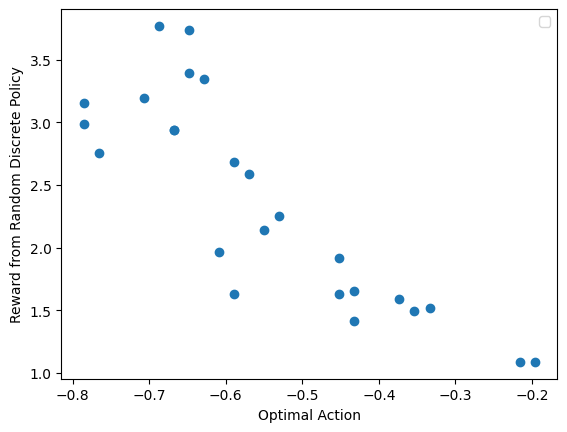

In [41]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [42]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 3125)


In [43]:
print(df_hist)

[[0.86257813 1.         1.         ... 1.         1.         1.        ]
 [0.69874336 1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


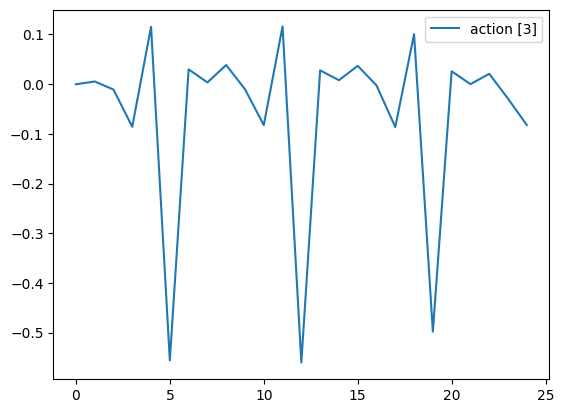

In [44]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

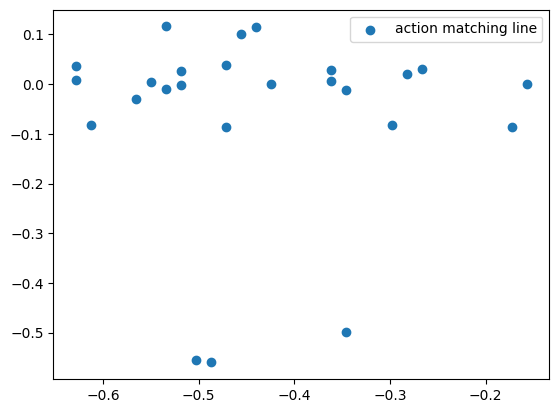

In [45]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [47]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [48]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [49]:
o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles

In [50]:
ana_sum = -np.sum(o_vals, axis=1) * 0.025
ana_sum

array([-0.        , -0.01963495, -0.03926991, ..., -0.35342917,
       -0.37306413, -0.39269908])

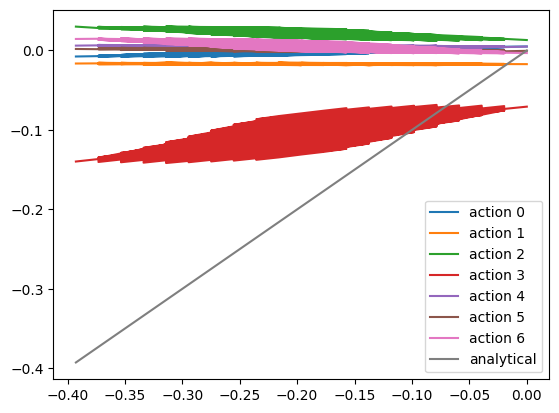

In [51]:
actions = np.array(actions)

for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

## Running Training with Scaleable Algo

In [33]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
from collections import deque
from sklearn.cluster import KMeans

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(fidelity_range, env.fidelity_history, label="Circuit Fidelity")
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(-np.log10(1. - np.mean(env.reward_history, axis=1)), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            ax[2 + qubit_idx * 2].errorbar(
                angles, marginal_rewards, yerr=marginal_std, fmt='-o', label=f"Qubit {qubit_idx} Reward History"
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            ax[3 + qubit_idx * 2].scatter(
                angles, marginal_probs, label=f"Qubit {qubit_idx} Probability Weights"
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn()
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

class PPO_ClusterCurriculum:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        num_warmup_updates: int = 100,
        context_buffer_size: int = 10000,
        noise_scale: float = 0.1,
        sampling_prob: float = 0.8,
        n_clusters: int = 50,
        cluster_update_freq: int = 1000,
    ):
        self.agent_config = agent_config
        self.exp_name = agent_config["exp_name"]
        self.seed = agent_config["seed"]
        self.torch_deterministic = agent_config["torch_deterministic"]
        self.cuda = agent_config["cuda"]
        self.track = agent_config["track"]
        self.wandb_project_name = agent_config["wandb_project_name"]
        self.wandb_entity = agent_config["wandb_entity"]
        self.save_model = agent_config["save_model"]
        self.plot_real_time = agent_config["plot_real_time"]
        self.num_prints = agent_config["num_prints"]

        self.num_updates = agent_config["total_updates"]
        self.learning_rate = agent_config["learning_rate"]
        self.num_envs = agent_config["num_envs"]
        self.num_steps = agent_config["num_steps"]
        self.anneal_lr = agent_config["anneal_lr"]
        self.anneal_num_updates = agent_config["anneal_num_updates"]
        self.exp_anneal_lr = agent_config["exp_anneal_lr"]
        self.exp_update_time = agent_config["exp_update_time"]
        self.plateau_lr = agent_config["plateau_lr"]
        self.gamma = agent_config["gamma"]
        self.gae_lambda = agent_config["gae_lambda"]
        self.num_minibatches = agent_config["num_minibatches"]
        self.update_epochs = agent_config["update_epochs"]
        self.norm_adv = agent_config["norm_adv"]
        self.activation_function_str = agent_config["activation_function_str"]
        self.use_combined_networks = agent_config["use_combined_networks"]
        self.layer_size = agent_config["layer_size"]
        self.clip_coef = agent_config["clip_coef"]
        self.clip_vloss = agent_config["clip_vloss"]
        self.ent_coef = agent_config["ent_coef"]
        self.vf_coef = agent_config["vf_coef"]
        self.max_grad_norm = agent_config["max_grad_norm"]
        self.target_kl = agent_config["target_kl"]
        self.robust_ppo = agent_config["robust_ppo"]

        # --- UPDATED: Attributes for Clustering Curriculum ---
        self.num_warmup_updates = num_warmup_updates
        self.noise_scale = noise_scale
        self.SAMPLING_PROB = sampling_prob
        self.n_clusters = n_clusters
        self.cluster_update_freq = cluster_update_freq

        # Use a deque for an efficient fixed-size FIFO buffer
        self.context_buffer = deque(maxlen=context_buffer_size)
        self.context_rewards = deque(maxlen=context_buffer_size)
        self.mean_action_buffer = deque(maxlen=context_buffer_size) # NEW: Buffer for actions

        # State for the clustering model
        self.kmeans_model = None
        self.cluster_rewards_avg = np.array([])
        self.cluster_probs = np.array([])
        
        # --- Optional: For logging/debugging ---
        self.sampling_sources = []
        self.noise_magnitudes = []

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_ClusterCurriculum__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb
            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s" % (
                "\n".join([f"|{key}|{value}|" for key, value in self.agent_config.items()])
            )
        )

        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.env = env

        self.agent = Agent(
            self.env, self.use_combined_networks, self.activation_function_str,
            self.layer_size, self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.learning_rate, eps=1e-5)

    def plot_context_history(self):
        updates, contexts = zip(*self.context_history)
        contexts = np.array(contexts)
        plt.figure(figsize=(10, 6))
        for i in range(contexts.shape[1]):
            plt.plot(updates, contexts[:, i], label=f"Context Dim {i}")
        plt.xlabel("Update")
        plt.ylabel("Context Value")
        plt.title("Context Sampling History")
        plt.legend()
        plt.savefig(f"runs/{self.run_name}/context_history.png")
        plt.close()

    def add_to_context_buffer(self, context: np.ndarray, reward: float, mean_action: np.ndarray):
        """Adds context, reward, and the agent's mean action to their respective buffers."""
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        self.mean_action_buffer.append(mean_action) # NEW: Store the action

    def _update_clusters(self):
        """
        Fits a k-means model on the context buffer and calculates sampling
        probabilities for each cluster based on their average performance.
        """
        if len(self.context_buffer) < self.n_clusters:
            print("INFO: Not enough data to form clusters yet.")
            return

        print(f"INFO: Updating curriculum clusters...")
        contexts = np.array(self.context_buffer)
        rewards = np.array(self.context_rewards)

        self.kmeans_model = KMeans(n_clusters=self.n_clusters, n_init='auto', random_state=self.seed)
        self.kmeans_model.fit(contexts)

        self.cluster_rewards_avg = np.zeros(self.n_clusters)
        cluster_counts = np.zeros(self.n_clusters)
        for i, label in enumerate(self.kmeans_model.labels_):
            self.cluster_rewards_avg[label] += rewards[i]
            cluster_counts[label] += 1
        
        cluster_counts[cluster_counts == 0] = 1e-6
        self.cluster_rewards_avg /= cluster_counts

        # Using a stable '4 - R' weighting, assuming max reward is 4
        prob_weights = 4.0 - self.cluster_rewards_avg
        prob_weights = np.clip(prob_weights, a_min=0, a_max=None)
        
        if np.sum(prob_weights) < 1e-6:
            self.cluster_probs = np.ones(self.n_clusters) / self.n_clusters
        else:
            self.cluster_probs = prob_weights / np.sum(prob_weights)

    def sample_context(self, update_step: int) -> np.ndarray:
        """
        Samples a context using the clustering curriculum. Periodically updates
        the clusters based on the agent's performance.
        """
        is_warmup = update_step <= self.num_warmup_updates
        
        if update_step % self.cluster_update_freq == 0:
            self._update_clusters()

        if is_warmup or self.kmeans_model is None:
            self.sampling_sources.append("random_warmup")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

        if np.random.random() < self.SAMPLING_PROB:
            chosen_cluster_idx = np.random.choice(self.n_clusters, p=self.cluster_probs)
            centroid = self.kmeans_model.cluster_centers_[chosen_cluster_idx]
            noise = np.random.normal(0, self.noise_scale, centroid.shape)
            context = centroid + noise
            self.noise_magnitudes.append(np.linalg.norm(noise))
            self.sampling_sources.append("cluster_buffer")
            return np.clip(
                context,
                self.env.observation_space.low,
                self.env.observation_space.high
            )
        else:
            self.sampling_sources.append("random_explore")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )
        
    def plot_curriculum_state(self, filename="curriculum_state.png"):
        """
        Plots the distribution of rewards in the buffer and the distribution
        of the average rewards of the clusters.
        """
        if not self.context_rewards:
            print("No rewards in buffer to plot.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

        ax[0].hist(list(self.context_rewards), bins=40, density=True, alpha=0.75, color='royalblue')
        ax[0].set_title("Distribution of All Point Rewards in Buffer")
        ax[0].set_xlabel("Reward")
        ax[0].set_ylabel("Density")
        mean_reward = np.mean(list(self.context_rewards))
        ax[0].axvline(mean_reward, color='red', linestyle='--', label=f'Mean: {mean_reward:.2f}')
        ax[0].legend()

        if self.cluster_rewards_avg.size > 0:
            ax[1].hist(self.cluster_rewards_avg, bins=20, density=True, alpha=0.75, color='seagreen')
            ax[1].set_title(f"Distribution of Avg. Rewards Across {self.n_clusters} Clusters")
            ax[1].set_xlabel("Average Cluster Reward")
            mean_cluster_reward = np.mean(self.cluster_rewards_avg)
            ax[1].axvline(mean_cluster_reward, color='red', linestyle='--', label=f'Mean: {mean_cluster_reward:.2f}')
            ax[1].legend()
        else:
            ax[1].set_title("Cluster Rewards (Not yet computed)")
            ax[1].text(0.5, 0.5, "Run more steps to compute clusters.", ha='center', va='center')

        fig.suptitle("Curriculum State Dashboard", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_policy_behaviour(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="policy_behaviour.png"
    ):
        """
        Plots the agent's reward against the optimal action required to
        counteract spillover noise.

        A robust agent should show a flat reward profile, while a naive
        agent's reward will decrease as the optimal action magnitude increases.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot policy behaviour.")
        #     return

        # 1. Convert buffers to numpy arrays for calculation
        obs_arr = np.array(self.context_buffer)
        rewards_arr = np.array(self.context_rewards)

        # 2. Calculate the optimal action based on the provided formula
        # Assumes the dimensions of obs_arr correspond to the spillover_qubits
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        
        # Calculate the total spillover angle for each context in the buffer
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        
        # The optimal action is the one that perfectly cancels this spillover
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)
        
        # Scatter plot of raw data points
        plt.scatter(optimal_action, rewards_arr, alpha=0.1, label='Raw Data Points', color='royalblue')

        # Calculate and plot a binned average to show the trend clearly
        try:
            bins = np.linspace(optimal_action.min(), optimal_action.max(), 15)
            bin_indices = np.digitize(optimal_action, bins)
            binned_rewards_mean = [rewards_arr[bin_indices == i].mean() for i in range(1, len(bins))]
            binned_rewards_std = [rewards_arr[bin_indices == i].std() for i in range(1, len(bins))]
            bin_centers = (bins[:-1] + bins[1:]) / 2

            plt.errorbar(
                bin_centers,
                binned_rewards_mean,
                yerr=binned_rewards_std,
                fmt='-o',
                color='red',
                markersize=8,
                capsize=5,
                linewidth=2.5,
                label='Binned Average Reward'
            )
        except Exception as e:
            print(f"Could not compute binned average for policy behaviour plot: {e}")

        plt.title("Agent Reward vs. Optimal Corrective Action")
        plt.xlabel("Optimal Action Magnitude (to counteract spillover)")
        plt.ylabel("Achieved Reward")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()

    def run_training(self):
        self.obs = torch.zeros((self.num_steps, self.num_envs) + self.env.observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.num_steps, self.num_envs) + self.env.action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            context = self.sample_context(update_step=update)
            angles = self.env.unwrapped.obs_raw_to_angles(context)
            next_obs, _ = self.env.unwrapped.reset(debug_obs=angles)

            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(next_obs)
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                cpu_action = action.cpu().numpy()
                # The mean action over the parallel environments for this step
                mean_action_for_step = np.mean(cpu_action, axis=0) 
                try:
                    self.env.unwrapped.mean_action = self.env.action(mean_action_for_step)
                except AttributeError:
                    self.env.unwrapped.mean_action = mean_action_for_step

                next_obs, reward, terminations, truncations, infos = self.env.step(cpu_action)

                mean_reward = np.mean(reward)
                # UPDATED: Pass the mean action to the buffer
                self.add_to_context_buffer(context, mean_reward, mean_action_for_step) 

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    # context = self.sample_context(warmup=is_warmup)
                    # self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                            self.writer.add_scalar("charts/episodic_return", info['episode']['r'], global_step)
                            self.writer.add_scalar("charts/episodic_length", info['episode']['l'], global_step)

            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + self.values

            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(newvalue - b_values[mb_inds], -self.clip_coef, self.clip_coef)
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)
                    self.plot_curriculum_state()
                    gamma_matrix = self.env.unwrapped.gamma_matrix # Assuming gamma is in your env
                    self.plot_policy_behaviour(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[2, 4], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.2         # As per your example
                    )

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [37]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(fidelity_range, env.fidelity_history, label="Circuit Fidelity")
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(-np.log10(1. - np.mean(env.reward_history, axis=1)), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            ax[2 + qubit_idx * 2].errorbar(
                angles, marginal_rewards, yerr=marginal_std, fmt='-o', label=f"Qubit {qubit_idx} Reward History"
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            ax[3 + qubit_idx * 2].scatter(
                angles, marginal_probs, label=f"Qubit {qubit_idx} Probability Weights"
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn()
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        # --- NEW: Hyperparameters Tuned for Shorter Training Runs ---
        num_warmup_updates: int = 20,
        context_buffer_size: int = 500,
        sampling_prob: float = 0.3,
        eviction_strategy: str = 'hybrid', # 'fifo' or 'hybrid'
        evict_best_prob: float = 0.2, # Probability of evicting highest-reward sample
        anneal_noise: bool = True,
        initial_noise_scale: float = 0.15,
        final_noise_scale: float = 0.05,
    ):
        self.agent_config = agent_config
        self.exp_name = agent_config["exp_name"]
        self.seed = agent_config["seed"]
        self.torch_deterministic = agent_config["torch_deterministic"]
        self.cuda = agent_config["cuda"]
        self.track = agent_config["track"]
        self.wandb_project_name = agent_config["wandb_project_name"]
        self.wandb_entity = agent_config["wandb_entity"]
        self.save_model = agent_config["save_model"]
        self.plot_real_time = agent_config["plot_real_time"]
        self.num_prints = agent_config["num_prints"]

        self.num_updates = agent_config["total_updates"]
        self.learning_rate = agent_config["learning_rate"]
        self.num_envs = agent_config["num_envs"]
        self.num_steps = agent_config["num_steps"]
        self.anneal_lr = agent_config["anneal_lr"]
        self.anneal_num_updates = agent_config["anneal_num_updates"]
        self.exp_anneal_lr = agent_config["exp_anneal_lr"]
        self.exp_update_time = agent_config["exp_update_time"]
        self.plateau_lr = agent_config["plateau_lr"]
        self.gamma = agent_config["gamma"]
        self.gae_lambda = agent_config["gae_lambda"]
        self.num_minibatches = agent_config["num_minibatches"]
        self.update_epochs = agent_config["update_epochs"]
        self.norm_adv = agent_config["norm_adv"]
        self.activation_function_str = agent_config["activation_function_str"]
        self.use_combined_networks = agent_config["use_combined_networks"]
        self.layer_size = agent_config["layer_size"]
        self.clip_coef = agent_config["clip_coef"]
        self.clip_vloss = agent_config["clip_vloss"]
        self.ent_coef = agent_config["ent_coef"]
        self.vf_coef = agent_config["vf_coef"]
        self.max_grad_norm = agent_config["max_grad_norm"]
        self.target_kl = agent_config["target_kl"]
        self.robust_ppo = agent_config["robust_ppo"]

        # --- UPDATED: Attributes for Fast Rank-Based Curriculum ---
        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.SAMPLING_PROB = sampling_prob
        self.eviction_strategy = eviction_strategy
        self.evict_best_prob = evict_best_prob
        self.anneal_noise = anneal_noise
        self.initial_noise_scale = initial_noise_scale
        self.final_noise_scale = final_noise_scale

        # Using standard lists to allow for custom eviction logic
        self.context_buffer = []
        self.context_rewards = []
        self.mean_action_buffer = []

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb
            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s" % (
                "\n".join([f"|{key}|{value}|" for key, value in self.agent_config.items()])
            )
        )

        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.env = env

        self.agent = Agent(
            self.env, self.use_combined_networks, self.activation_function_str,
            self.layer_size, self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.learning_rate, eps=1e-5)

    def add_to_context_buffer(self, context: np.ndarray, reward: float, mean_action: np.ndarray):
        """
        Adds context, reward, and action to buffers.
        Applies a hybrid eviction strategy if the buffer is full.
        """
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        self.mean_action_buffer.append(mean_action)

        # Eviction logic for when buffer exceeds its maximum size
        if len(self.context_buffer) > self.context_buffer_size:
            if self.eviction_strategy == 'hybrid' and np.random.random() < self.evict_best_prob:
                # Evict the sample with the highest reward (easiest success)
                idx_to_remove = np.argmax(self.context_rewards)
            else:
                # Evict the oldest sample (FIFO)
                idx_to_remove = 0
            
            self.context_buffer.pop(idx_to_remove)
            self.context_rewards.pop(idx_to_remove)
            self.mean_action_buffer.pop(idx_to_remove)
    
    def sample_context(self, update_step: int) -> np.ndarray:
        """
        Samples context using rank-based prioritized replay, tailored for short runs.
        """
        is_warmup = update_step <= self.num_warmup_updates
        
        if is_warmup or len(self.context_buffer) == 0:
            # self.sampling_sources.append("random_warmup")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

        if np.random.random() < self.SAMPLING_PROB:
            # --- Rank-Based Prioritized Point Replay ---
            rewards = np.array(self.context_rewards)
            # Lower reward gets lower rank (e.g., rank 1 is the hardest)
            ranks = np.argsort(np.argsort(rewards)) + 1
            # Probability is inversely proportional to rank
            prob_weights = 1.0 / ranks
            prob_weights /= np.sum(prob_weights) # Normalize

            idx = np.random.choice(len(self.context_buffer), p=prob_weights)
            context = self.context_buffer[idx]
            
            # --- Optional: Anneal noise scale over the training run ---
            if self.anneal_noise:
                progress = (update_step - self.num_warmup_updates) / (self.num_updates - self.num_warmup_updates)
                progress = np.clip(progress, 0.0, 1.0)
                current_noise_scale = self.initial_noise_scale * (1 - progress) + self.final_noise_scale * progress
            else:
                current_noise_scale = self.initial_noise_scale

            noise = np.random.normal(0, current_noise_scale, context.shape)
            noisy_context = context + noise
            
            # self.noise_magnitudes.append(np.linalg.norm(noise))
            # self.sampling_sources.append("buffer_ranked")
            return np.clip(
                noisy_context,
                self.env.observation_space.low,
                self.env.observation_space.high
            )
        else:
            # self.sampling_sources.append("random_explore")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

    def plot_buffer_reward_distribution(self, filename="buffer_reward_distribution.png"):
        """Plot histogram of rewards in the buffer."""
        # This function is relevant again for point-based replay
        if not self.context_rewards:
            print("No rewards in buffer to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.hist(self.context_rewards, bins=30, density=True, alpha=0.7, label="Buffer Rewards")
        plt.xlabel("Reward")
        plt.ylabel("Density")
        plt.title("Distribution of Rewards in Context Buffer")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"Buffer reward stats - Mean: {np.mean(self.context_rewards):.3f}, Std: {np.std(self.context_rewards):.3f}")
    
    def plot_policy_behaviour(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="policy_behaviour.png"
    ):
        """
        Plots the agent's reward against the optimal action required to
        counteract spillover noise.

        A robust agent should show a flat reward profile, while a naive
        agent's reward will decrease as the optimal action magnitude increases.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot policy behaviour.")
        #     return

        # 1. Convert buffers to numpy arrays for calculation
        obs_arr = np.array(self.context_buffer)
        rewards_arr = np.array(self.context_rewards)

        # 2. Calculate the optimal action based on the provided formula
        # Assumes the dimensions of obs_arr correspond to the spillover_qubits
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        
        # Calculate the total spillover angle for each context in the buffer
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        
        # The optimal action is the one that perfectly cancels this spillover
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)
        
        # Scatter plot of raw data points
        plt.scatter(optimal_action, rewards_arr, alpha=0.1, label='Raw Data Points', color='royalblue')

        # Calculate and plot a binned average to show the trend clearly
        try:
            bins = np.linspace(optimal_action.min(), optimal_action.max(), 15)
            bin_indices = np.digitize(optimal_action, bins)
            binned_rewards_mean = [rewards_arr[bin_indices == i].mean() for i in range(1, len(bins))]
            binned_rewards_std = [rewards_arr[bin_indices == i].std() for i in range(1, len(bins))]
            bin_centers = (bins[:-1] + bins[1:]) / 2

            plt.errorbar(
                bin_centers,
                binned_rewards_mean,
                yerr=binned_rewards_std,
                fmt='-o',
                color='red',
                markersize=8,
                capsize=5,
                linewidth=2.5,
                label='Binned Average Reward'
            )
        except Exception as e:
            print(f"Could not compute binned average for policy behaviour plot: {e}")

        plt.title("Agent Reward vs. Optimal Corrective Action")
        plt.xlabel("Optimal Action Magnitude (to counteract spillover)")
        plt.ylabel("Achieved Reward")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()

    def plot_action_comparison(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="action_comparison.png"
    ):
        """
        Plots the agent's actual output action against the analytically
        calculated optimal action.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot action comparison.")
        #     return

        # 1. Get data from buffers
        obs_arr = np.array(self.context_buffer)
        agent_actions = np.array(self.mean_action_buffer)

        # 2. Calculate the optimal action for each observation
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)

        # Plot each dimension of the agent's action
        for i in range(agent_actions.shape[1]):
            if i == 3:
                plt.scatter(
                    optimal_action, 
                    agent_actions[:, i], 
                    alpha=0.2, 
                    label=f'Agent Action Dim {i}'
                )

        # Plot the "perfect" policy line for reference
        plt.plot(
            optimal_action, 
            optimal_action, 
            'r--', 
            linewidth=2.5, 
            label='Analytical Optimal (y=x)'
        )

        plt.title("Agent's Learned Action vs. Optimal Action")
        plt.xlabel("Optimal Corrective Action (Calculated)")
        plt.ylabel("Actual Action (From Agent Policy)")
        plt.legend()
        plt.grid(True, which='both', linestyle='--')
        # plt.axis('equal') # Ensures the y=x line is at a 45-degree angle
        plt.show()
    
    def run_training(self):
        self.obs = torch.zeros((self.num_steps, self.num_envs) + self.env.observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.num_steps, self.num_envs) + self.env.action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            context = self.sample_context(update_step=update)
            angles = self.env.unwrapped.obs_raw_to_angles(context)
            next_obs, _ = self.env.unwrapped.reset(debug_obs=angles)

            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(next_obs)
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                cpu_action = action.cpu().numpy()
                # The mean action over the parallel environments for this step
                mean_action_for_step = np.mean(cpu_action, axis=0) 
                try:
                    self.env.unwrapped.mean_action = self.env.action(mean_action_for_step)
                except AttributeError:
                    self.env.unwrapped.mean_action = mean_action_for_step

                next_obs, reward, terminations, truncations, infos = self.env.step(cpu_action)

                mean_reward = np.mean(reward)
                # UPDATED: Pass the mean action to the buffer
                self.add_to_context_buffer(context, mean_reward, mean_action_for_step) 

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    # context = self.sample_context(warmup=is_warmup)
                    # self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                            self.writer.add_scalar("charts/episodic_return", info['episode']['r'], global_step)
                            self.writer.add_scalar("charts/episodic_length", info['episode']['l'], global_step)

            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + self.values

            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(newvalue - b_values[mb_inds], -self.clip_coef, self.clip_coef)
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)
                    self.plot_buffer_reward_distribution()
                    gamma_matrix = self.env.unwrapped.gamma_matrix # Assuming gamma is in your env
                    self.plot_policy_behaviour(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )
                    self.plot_action_comparison(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [38]:
# PPO Details

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 800,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 800,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
# ppo_agent = PPO_ClusterCurriculum(
#     agent_config, 
#     rescaled_q_env,
#     num_warmup_updates=20,
#     context_buffer_size=75,
#     noise_scale=0.1,
#     sampling_prob=0.4,
#     n_clusters=25,
#     cluster_update_freq=10,
# )

ppo_agent = PPO_ContextBuffer(
    agent_config, 
    rescaled_q_env,
    num_warmup_updates=20,
    context_buffer_size=100,
    sampling_prob=0.25,
    eviction_strategy='hybrid', # 'fifo' or 'hybrid'
    evict_best_prob=0.2, # Probability of evicting highest-reward sample
    anneal_noise=True,
    initial_noise_scale=0.15,
    final_noise_scale=0.05,
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


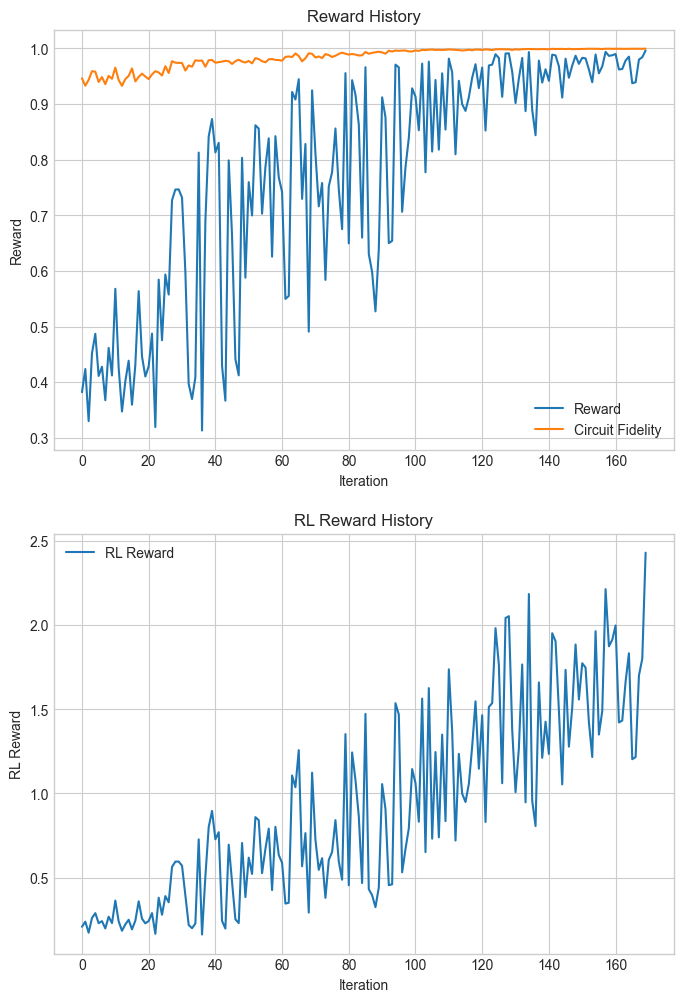

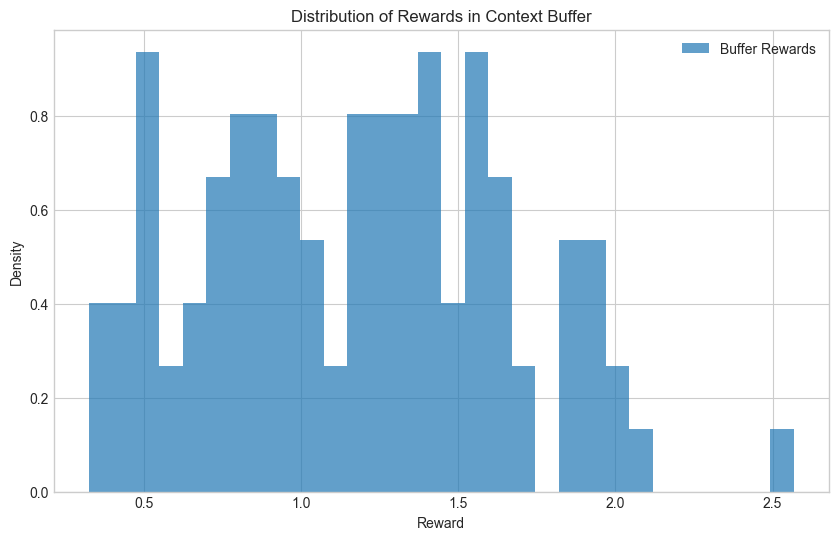

Buffer reward stats - Mean: 1.173, Std: 0.473


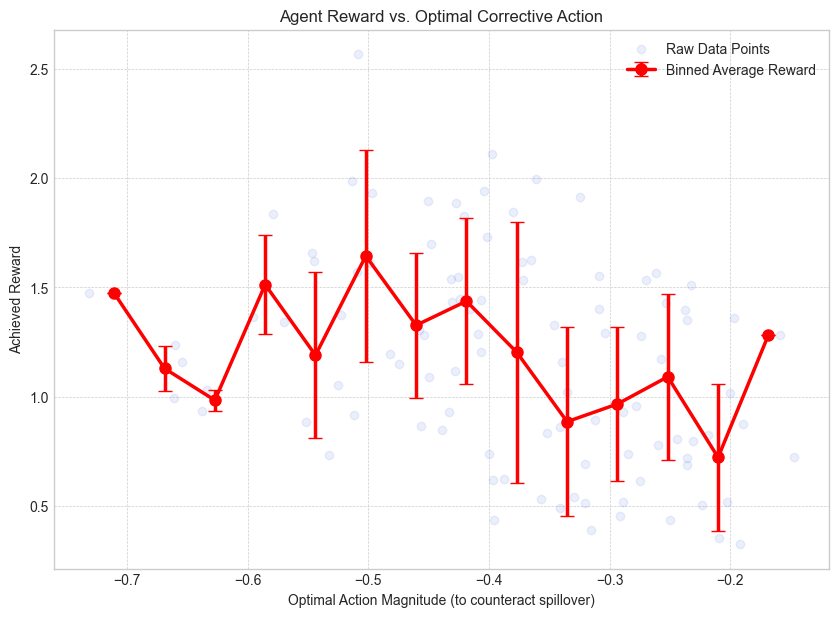

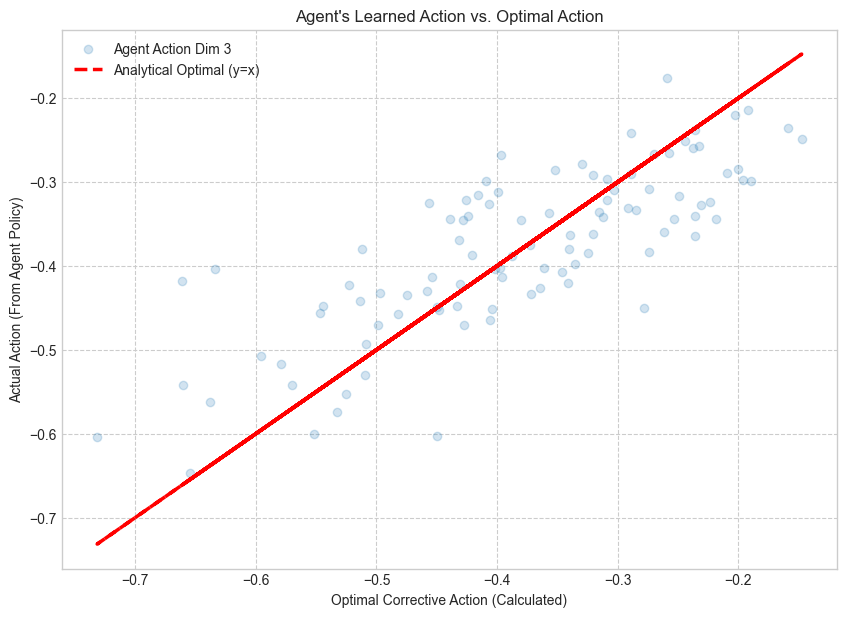

Sampled angles:  [2.89254939 0.03647519 0.78156943 0.         2.3926126  0.92504693]
Environment Observation: [ 0.84145414 -0.97677917 -0.50243745  0.52318449 -0.41109683]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


KeyboardInterrupt: 

In [39]:
ppo_agent.run_training()

In [37]:
NUM_EVAL = 100
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    obs_angles = 0.5 * (obs + 1) * np.pi
    computed_angles = obs_angles * gamma_matrix[[0, 1, 2, 4, 5], 3]
    spillover_angle = np.sum(computed_angles)
    action_scaled = -spillover_angle / 0.25
    print(action_scaled)
    batch_action[:,3] = action_scaled
    # print(batch_action.shape)
    # assert False
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [2.41712919 2.37914676 0.73705187 0.         1.14621576 2.43356161]
Environment Observation: [ 0.53879223  0.51461187 -0.5307782  -0.27029638  0.54925344]
-0.4291776823468856
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999788451003764
Reward (avg): 0.9994785620019107 Std: 0.0003738318681709072
obs: [ 0.53879223  0.51461187 -0.5307782  -0.27029638  0.54925344]
reward: [3.80219337 3.29045779 3.92681056 3.57837338 3.80799968 3.38522721
 2.90527918 3.33514148 3.39531177 3.31216287 2.97541093 3.71995439
 3.37521391 3.34468749 3.0124193  2.9968917  3.13248478 3.62599238
 3.47061892 3.96438338 3.5028153  3.00016405 3.64058333 3.196905
 3.57188786 3.31924634 3.67094966 3.10174467 3.42759894 3.3403314
 3.3950513  2.74826649]
Sampled angles:  [1.54838972 0.09307671 2.25608282 0.         1.75691793 1.58992248]
Environment Observation: [-0.01426449 -0.94074553  0.43626693  0.11848869  0.01217609]
-0.49958783735119483
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999808250369895
Reward (avg): 0.999893891677662 Std: 0.00010105321445480626
obs: [-0.01426449 -0.94074553  0.43626693  0.11848869  0.01217609]
reward: [3.76723792 4.73711071 4.33872863 3.77626904 4.19902713 4.39392181
 4.0150033  3.97572934 3.42741724 3.67657238 4.23704882 4.3720387
 4.02171197 4.26821193 4.5202014  4.62607194 4.85167855 3.76685725
 3.57054589 4.09553672 3.8172157  5.32974301 4.87139674 3.94607751
 4.37366062 4.29525115 3.39827811 3.56961344 4.06532375 4.72659101
 4.01079695 4.76565141]
Sampled angles:  [1.60276384 2.69607329 0.6086675  0.         1.77660759 2.64110151]
Environment Observation: [ 0.02035115  0.71637356 -0.61251024  0.13102352  0.68137744]
-0.48406977720124067
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999754053476702
Reward (avg): 0.999281375764043 Std: 0.00040337865086145395
obs: [ 0.02035115  0.71637356 -0.61251024  0.13102352  0.68137744]
reward: [3.08151675 2.84673237 2.88063873 3.84337136 3.38123226 2.97591881
 2.77152871 3.54862098 3.44400223 3.87590657 3.61819338 3.21191187
 3.3556654  3.24544038 3.05524879 2.83912223 3.05781665 3.1397644
 3.10377248 2.99154184 3.38306401 3.63276503 3.16246514 3.07952688
 3.13291726 2.97781329 2.98588097 4.42526759 3.11190793 3.20648365
 3.03332022 3.40225696]
Sampled angles:  [1.37162396 1.2447634  2.1748784  0.         2.90530427 2.40208578]
Environment Observation: [-0.12679706 -0.207559    0.38457059  0.84957414  0.5292153 ]
-0.681324713677472
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999782315181457
Reward (avg): 0.9998451873742031 Std: 0.00014087924101274682
obs: [-0.12679706 -0.207559    0.38457059  0.84957414  0.5292153 ]
reward: [3.37026589 3.75006406 4.23754205 4.43464488 4.42420048 3.89974342
 3.5535561  3.81325298 3.47739839 4.26795692 4.14271579 3.52892659
 3.91319168 3.83822123 4.51240994 4.20972251 3.64209823 3.66477637
 4.18610184 4.57093692 3.93246278 4.08478773 3.89670877 3.17802129
 4.53545171 3.84741369 3.40010648 3.686758   4.20217498 4.3307684
 4.20898024 4.14567621]
Sampled angles:  [1.16451523 1.54910236 1.3449905  0.         0.22916218 0.34477733]
Environment Observation: [-0.25864658 -0.01381081 -0.14375246 -0.85411083 -0.78050793]
-0.2564607597044042
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999763051729955
Reward (avg): 0.9997040698641729 Std: 0.0002855888242954463
obs: [-0.25864658 -0.01381081 -0.14375246 -0.85411083 -0.78050793]
reward: [4.22089722 3.38776774 3.63634422 3.3384277  3.29151909 4.59191885
 4.37783713 3.77810624 4.48437384 3.83033529 4.57575399 3.5092215
 2.95610369 4.70704381 3.43195563 3.59820138 3.73025511 3.82016407
 4.22457419 3.66810461 4.14458958 4.42721514 3.41154473 3.42612264
 3.58253787 3.21716988 3.32887349 3.68299817 3.45059036 4.01255182
 3.25124256 2.89951931]
Sampled angles:  [0.3568698  0.43517875 2.10410038 0.         1.18642871 2.05142884]
Environment Observation: [-0.77280963 -0.7229566   0.33951191 -0.24469602  0.30598016]
-0.43565460893655206
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999798726504316
Reward (avg): 0.9998406728261668 Std: 0.00013005105692196476
obs: [-0.77280963 -0.7229566   0.33951191 -0.24469602  0.30598016]
reward: [4.85679866 4.19261648 4.6133264  4.43943795 4.05787811 3.4137437
 3.83950348 3.69919983 3.5619055  3.73313525 3.22471014 4.30788397
 4.21944002 3.52313701 3.68679053 3.71774313 3.97045343 3.80121695
 3.54391021 3.94418201 4.36806169 4.63627957 4.10207843 4.09480371
 3.917761   3.68094285 3.67405683 4.6998814  4.17515298 3.41524355
 4.01871622 3.54972442]
Sampled angles:  [2.60256339 0.61418452 1.91403584 0.         0.70381851 2.01098701]
Environment Observation: [ 0.65684331 -0.60899799  0.21851306 -0.55193522  0.28023409]
-0.41884356323509714
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999813397262911
Reward (avg): 0.9998031049252541 Std: 0.00017686778040386237
obs: [ 0.65684331 -0.60899799  0.21851306 -0.55193522  0.28023409]
reward: [3.699511   4.15475929 3.60648743 3.77013212 3.67676503 4.30428403
 4.91670451 3.71456393 3.56125236 4.70195934 4.97794581 4.19270895
 4.37036333 3.74223182 3.82104296 3.55757563 3.41770416 3.86891282
 4.21610584 3.80923059 3.35434505 3.89542729 3.38817807 3.04022712
 3.5669641  3.40368673 4.21983237 3.9935633  3.50551832 3.61936593
 4.14777002 4.27579619]
Sampled angles:  [1.90026278 0.27231464 1.41962961 0.         0.78662223 3.04444406]
Environment Observation: [ 0.20974486 -0.82663912 -0.09623572 -0.49922074  0.93815328]
-0.3913007875273242
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999795224899222
Reward (avg): 0.9997848127721953 Std: 0.00024083076397405086
obs: [ 0.20974486 -0.82663912 -0.09623572 -0.49922074  0.93815328]
reward: [3.91011675 4.11929091 3.95730271 3.88013041 3.45093789 4.02322728
 4.00208905 4.30449696 4.33226842 3.69156596 3.54797267 4.55257783
 4.38307674 4.09487038 3.80025841 4.05794682 4.55776934 3.44841855
 3.3028564  3.11035841 3.84741497 4.68153103 3.6088825  2.97272651
 3.20450308 4.45442775 3.91135072 3.44331921 4.42935779 4.01614809
 3.31376078 4.59614372]
Sampled angles:  [2.43727799 2.62380227 3.03722104 0.         1.79674612 1.16290616]
Environment Observation: [ 0.55161936  0.67036441  0.93355496  0.1438441  -0.25967094]
-0.6836106126938376
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999762246046067
Reward (avg): 0.9999393704124084 Std: 4.4095507486203685e-05
obs: [ 0.55161936  0.67036441  0.93355496  0.1438441  -0.25967094]
reward: [4.86883214 4.49679046 4.63335613 4.17359183 4.71379294 3.91572094
 4.56983804 4.08908781 4.59040907 4.98164328 4.05025491 4.25090965
 3.84575279 4.10212766 4.28640877 4.61480652 4.50152398 5.24870233
 4.3414915  4.02880762 4.3929148  3.90923575 4.19606874 3.95273842
 4.45901029 3.97731009 4.3517354  4.87107999 3.75791734 4.82336812
 4.37808189 3.88068076]
Sampled angles:  [1.48408556 0.04052831 0.85562439 0.         0.36008991 1.07235773]
Environment Observation: [-0.05520179 -0.97419887 -0.45529259 -0.77075964 -0.31731587]
-0.19576858357953675
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999980391012363
Reward (avg): 0.9995558120157466 Std: 0.0005183000207560703
obs: [-0.05520179 -0.97419887 -0.45529259 -0.77075964 -0.31731587]
reward: [3.01061085 3.67639708 3.57990232 2.59917016 3.47110736 3.55695446
 3.42125425 3.833758   3.74368307 3.04947775 5.3407891  3.45526721
 3.13408371 3.54071788 3.99304085 2.93681647 3.28317471 3.64196699
 3.44737759 3.67004404 3.55776589 3.7013294  3.54462657 3.86778251
 3.77618625 3.58207435 3.79988969 3.72735338 2.74580207 3.9150723
 3.53784063 3.69955245]
Sampled angles:  [0.66587465 0.9500003  0.03329278 0.         1.60079274 2.21570053]
Environment Observation: [-0.57609103 -0.39521102 -0.97880516  0.01909631  0.41055876]
-0.30335407785514856
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999783422075095
Reward (avg): 0.9985518100637765 Std: 0.0009449508877209679
obs: [-0.57609103 -0.39521102 -0.97880516  0.01909631  0.41055876]
reward: [3.3695544  2.60039427 2.56633843 2.84375347 2.93426696 2.75356606
 2.48748005 2.73887848 2.76699253 2.99510166 3.51712782 2.4517577
 2.81418692 2.59628265 3.05674645 3.80750693 2.76359948 3.35503599
 3.73890096 3.07714712 2.90701655 2.82794777 2.73695385 2.83352711
 2.99749959 3.35455687 3.32137034 2.92670616 2.70379646 2.42768837
 2.94980564 3.35817578]
Sampled angles:  [0.92246939 2.76730192 1.1365916  0.         0.78804714 0.79639253]
Environment Observation: [-0.41273775  0.76171912 -0.27642332 -0.49831361 -0.49300077]
-0.3534610397776463
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999790112937921
Reward (avg): 0.9997603807575617 Std: 0.00023081706853911646
obs: [-0.41273775  0.76171912 -0.27642332 -0.49831361 -0.49300077]
reward: [3.26761113 4.5263138  4.24955353 3.96437887 3.75437992 5.10860913
 3.74425274 4.566286   4.11287839 3.40346651 4.18556177 3.67836053
 4.28816754 3.66746993 3.64282853 3.06556459 3.53855938 3.66133353
 4.06732132 3.70070826 3.15093144 5.17583777 4.06650151 3.22939236
 3.17105342 3.43081339 4.34234506 4.87483172 4.45834009 3.30186459
 3.81233152 3.32961209]
Sampled angles:  [0.57237835 0.52975467 0.28754688 0.         3.11777032 2.59478318]
Environment Observation: [-0.63561262 -0.6627477  -0.81694197  0.98483423  0.65189028]
-0.4769608004202788
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999760473171289
Reward (avg): 0.998803786913176 Std: 0.0009028692071424356
obs: [-0.63561262 -0.6627477  -0.81694197  0.98483423  0.65189028]
reward: [3.75354012 3.2861321  3.48652787 3.3898071  2.58317494 3.46085555
 3.06655374 2.74557874 2.82315603 2.93839862 3.1367067  3.34634094
 3.20764876 2.9455158  2.88820195 2.78993309 2.80293318 2.95275353
 2.57094528 2.94712101 2.62667566 2.36046541 3.1188593  3.189199
 3.60606844 3.0697384  2.98998601 2.62891655 4.16309282 3.02195823
 3.13146919 2.72825471]
Sampled angles:  [3.08010238 1.18641822 2.25267501 0.         0.17330707 2.39403295]
Environment Observation: [ 0.96085407 -0.24470271  0.43409745 -0.88966929  0.52408871]
-0.4474183019236309
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999742108743663
Reward (avg): 0.9998410129612899 Std: 0.0001413270381545208
obs: [ 0.96085407 -0.24470271  0.43409745 -0.88966929  0.52408871]
reward: [4.41861395 3.6574495  4.05679857 4.54776819 4.72034038 4.45749186
 4.00362497 4.30116764 3.42513319 4.02716273 4.20978434 3.70156913
 4.0308218  4.01690688 3.52026097 3.51409523 4.82619525 4.08888859
 3.21342674 3.87922221 3.40013448 3.57437846 4.07687378 5.21810205
 3.39009034 3.9500205  4.60438494 3.67342853 3.85324914 3.58781553
 4.23944131 3.75524169]
Sampled angles:  [3.11617303 0.35211492 0.31934106 0.         1.18057922 1.58135664]
Environment Observation: [ 0.98381737 -0.77583668 -0.79670117 -0.24841993  0.00672291]
-0.28965435110585075
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818878514856
Reward (avg): 0.9990968121131673 Std: 0.0007396580108796626
obs: [ 0.98381737 -0.77583668 -0.79670117 -0.24841993  0.00672291]
reward: [3.13276605 3.74611302 3.01048964 2.79475595 3.92758104 3.14429206
 3.2280671  3.08404384 3.08078996 3.77648144 3.39367834 3.1349605
 3.74387238 3.03182961 2.55371039 3.49846241 3.36777731 2.88074765
 3.52266306 2.8594993  3.2571781  3.56502789 2.8034951  2.8973524
 2.9193322  4.26057175 3.3280801  3.58348926 3.18748697 2.5387153
 2.73132116 2.63457339]
Sampled angles:  [2.80605935 2.03639832 2.63109639 0.         2.71095559 2.58370305]
Environment Observation: [0.78639286 0.29641143 0.67500798 0.72584793 0.64483645]
-0.7751304393051008
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999776372233319
Reward (avg): 0.9999249754875179 Std: 5.500702262030428e-05
obs: [0.78639286 0.29641143 0.67500798 0.72584793 0.64483645]
reward: [4.52009331 3.93536748 4.42936568 4.62017471 5.46478529 3.68944258
 4.68318481 4.26182092 3.89976362 4.40063109 5.2221389  4.00813085
 4.35352524 3.94444738 4.06212145 4.4329186  4.12372044 3.9284966
 4.44256397 4.0979917  4.11455299 4.07700755 5.19033289 3.99383948
 4.9787427  4.30889444 3.92556171 3.77804285 4.2368752  4.62719903
 3.6676275  3.85491605]
Sampled angles:  [0.92106632 3.11956974 2.14371556 0.         1.3412284  2.61267257]
Environment Observation: [-0.41363097  0.98597978  0.36473171 -0.14614748  0.66327901]
-0.596205414712399
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999760175897765
Reward (avg): 0.9998468651125603 Std: 0.00012436131127985212
obs: [-0.41363097  0.98597978  0.36473171 -0.14614748  0.66327901]
reward: [3.83761144 4.04542345 3.67196267 4.48416456 4.81512332 4.07060469
 4.00361544 4.06338682 3.7637695  4.67455059 4.14384728 4.7976925
 3.41818588 3.48705778 3.78716196 3.24183785 3.93183618 3.8888431
 3.96772194 4.06982034 4.33457563 3.89171379 3.65808744 3.63958739
 3.41995976 4.06643411 4.76883898 3.71025558 3.50921053 3.75241782
 4.01770776 4.06888132]
Sampled angles:  [2.68712897 1.00174758 2.26318961 0.         1.9688912  2.6250155 ]
Environment Observation: [ 0.71067943 -0.36226769  0.44079126  0.25343507  0.67113677]
-0.6220211838660883
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999828261818934
Reward (avg): 0.9999144462881813 Std: 8.735117322755915e-05
obs: [ 0.71067943 -0.36226769  0.44079126  0.25343507  0.67113677]
reward: [4.52775067 4.38206553 5.01521784 3.76698403 3.80102236 3.97837291
 3.5931638  5.43228301 3.77477956 4.22438972 4.13306063 3.35686616
 4.60662784 4.78360781 4.18363255 4.22773691 4.22635122 3.9688296
 3.86987318 4.32658373 4.09379528 4.30059664 4.64535477 4.41208089
 3.6895572  4.69934099 4.23012478 4.56065923 4.02226871 4.34942028
 4.51122451 4.45785167]
Sampled angles:  [0.13022039 1.67157611 1.44948729 0.         0.39522679 2.23516517]
Environment Observation: [-0.91709912  0.0641584  -0.07722773 -0.74839081  0.42295034]
-0.34334546622401757
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999765868058573
Reward (avg): 0.9998356336696889 Std: 0.00014830329527723432
obs: [-0.91709912  0.0641584  -0.07722773 -0.74839081  0.42295034]
reward: [4.03822516 4.6283659  3.78762429 4.00586349 3.68000998 3.75751369
 3.60876238 3.11028582 3.63979201 3.69144909 4.4028587  3.31484095
 4.09860589 4.33420533 3.65326815 3.61214675 3.93063616 3.95373852
 4.2652589  4.15168149 3.46424379 3.81396075 4.33738295 4.20633023
 3.61347637 3.74964827 4.44050569 4.02681174 3.71044487 3.969807
 4.19294661 4.28429064]
Sampled angles:  [2.84271421 0.00863596 0.2330888  0.         0.66903372 1.95596839]
Environment Observation: [ 0.80972807 -0.99450218 -0.85161106 -0.5740799   0.24520815]
-0.22565071003054935
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818069861712
Reward (avg): 0.9989820931244064 Std: 0.0007177479675039489
obs: [ 0.80972807 -0.99450218 -0.85161106 -0.5740799   0.24520815]
reward: [2.69138844 2.6588985  2.7459487  3.47586269 2.69142717 2.64271289
 2.72761629 3.21228682 3.14853086 2.64470782 3.36866934 3.41922799
 3.85565065 3.83889378 3.35345792 2.91301621 2.75969997 3.31584885
 3.94295985 2.86208813 2.90849701 3.20834714 3.14733679 3.26862419
 2.99041743 3.27421131 4.25139484 2.84756179 3.03028737 2.70181482
 3.34216587 3.33370847]
Sampled angles:  [2.42645275 2.80289135 2.92725862 0.         0.94915018 2.22682616]
Environment Observation: [ 0.5447278   0.78437606  0.86355071 -0.39575223  0.41764156]
-0.6373586349973941
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999780146936234
Reward (avg): 0.9999375295348689 Std: 4.8809875275990866e-05
obs: [ 0.5447278   0.78437606  0.86355071 -0.39575223  0.41764156]
reward: [3.99754222 4.40808356 4.20139416 4.36481458 4.30975983 4.09859628
 4.4044551  4.98582708 4.16805285 3.97862051 4.23875982 4.27697871
 4.48721345 4.31714373 3.63566469 4.21195287 4.39565041 4.19434273
 4.09989196 4.09797234 3.82057649 4.85213974 4.51661073 4.76872199
 4.77907763 4.68417517 5.41124116 4.66984785 4.33952163 4.04251655
 4.21112844 3.74161976]
Sampled angles:  [1.79639363 0.99859517 2.8530107  0.         0.42849589 1.92330584]
Environment Observation: [ 0.1436197  -0.36427457  0.81628303 -0.72721104  0.22441452]
-0.4809545724452787
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999806920823154
Reward (avg): 0.9999489228153988 Std: 4.1563677168368364e-05
obs: [ 0.1436197  -0.36427457  0.81628303 -0.72721104  0.22441452]
reward: [4.56744726 4.67464317 3.99256755 4.13519669 4.10884077 4.15136481
 4.84274276 3.90693937 4.23374348 4.66574765 4.40003107 4.46427675
 5.10839715 4.5200167  4.50191381 4.37632355 4.39272838 4.11323284
 4.81746792 4.36239333 3.6447988  4.53504462 4.07382638 4.52595424
 4.63742248 4.51016239 4.13503745 4.29552418 4.75872904 4.2387927
 4.40472628 4.68717545]
Sampled angles:  [2.51119049 3.04743162 0.37118872 0.         2.72685869 0.32931784]
Environment Observation: [ 0.59867352  0.94005523 -0.76369392  0.73597216 -0.79034975]
-0.4950985294569584
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999740231147175
Reward (avg): 0.9988054299732004 Std: 0.0008395277841803367
obs: [ 0.59867352  0.94005523 -0.76369392  0.73597216 -0.79034975]
reward: [2.65837139 2.79507865 2.4819252  3.52851854 2.73562982 2.69377467
 3.3134624  2.41814593 3.09302067 2.77956726 3.05114534 3.89725592
 2.69517605 2.99970018 2.9547139  2.85524285 3.35077732 3.33090132
 3.09226743 3.06093415 2.78107387 3.79542083 2.83864228 3.24831098
 3.1068342  3.36188921 3.60640956 3.29083341 2.89734523 2.87705974
 2.82890941 2.92539963]
Sampled angles:  [0.68139324 0.84936098 2.1467169  0.         0.57435134 0.65111625]
Environment Observation: [-0.56621159 -0.45928001  0.36664242 -0.63435658 -0.58548652]
-0.3457537780561092
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999760719778403
Reward (avg): 0.9997963326932854 Std: 0.00019883320617293955
obs: [-0.56621159 -0.45928001  0.36664242 -0.63435658 -0.58548652]
reward: [3.57887646 3.73566278 3.66132858 3.00272518 4.35361559 3.6121575
 3.7198251  4.56896618 3.43101008 4.65580676 3.72539453 3.17894552
 3.97531549 4.3169463  3.69962254 4.40280963 3.70492069 4.09455972
 3.41901134 3.64049311 4.02818038 4.54288427 4.48093296 3.71976461
 3.78989131 4.15971871 3.65521125 3.34785802 3.57547234 4.47924653
 4.05857847 3.71275622]
Sampled angles:  [1.16643144 0.94115451 0.92017148 0.         2.48599754 1.09530251]
Environment Observation: [-0.25742668 -0.40084243 -0.41420064  0.58263519 -0.30270876]
-0.44540381181077815
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999838880121392
Reward (avg): 0.9996162188073053 Std: 0.00034633248073961454
obs: [-0.25742668 -0.40084243 -0.41420064  0.58263519 -0.30270876]
reward: [3.31093962 3.13721273 4.01690291 4.41679463 3.50176812 3.872163
 3.2586445  4.05358682 3.40892909 3.47964839 3.47310108 3.63979639
 3.27949654 3.25167252 3.49169634 4.23302665 3.33308344 4.18594383
 2.73911263 4.17161163 3.00644262 3.21197238 3.25253714 3.3367177
 3.49399373 3.78254953 3.16806037 3.92184118 3.82103599 3.43089032
 3.88578956 3.95441393]
Sampled angles:  [0.31514173 2.79206313 2.47278079 0.         1.42568502 2.0088117 ]
Environment Observation: [-0.79937455  0.77748259  0.57422114 -0.09238072  0.27884925]
-0.5881844088702208
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999801806527522
Reward (avg): 0.9999280236944794 Std: 6.944756671331271e-05
obs: [-0.79937455  0.77748259  0.57422114 -0.09238072  0.27884925]
reward: [3.69325041 3.97733263 5.58084093 4.57853021 4.49503611 4.69890451
 3.57204809 4.4912232  3.76918418 5.02430723 4.39675083 5.85859716
 3.87348321 4.54154374 3.91476698 4.55877897 5.71011723 3.9384396
 5.07938129 3.8857243  5.00865027 4.05433283 4.32089488 3.84406819
 5.13396129 4.02219046 4.87634642 4.83234831 4.37439966 3.78986419
 3.77296706 4.48138418]
Sampled angles:  [1.17937775 0.53434169 2.71619792 0.         0.67996811 1.6914372 ]
Environment Observation: [-0.2491848  -0.65982751  0.7291853  -0.56711886  0.07680237]
-0.4522353135345303
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999771355478042
Reward (avg): 0.9999481328733013 Std: 3.780111991680997e-05
obs: [-0.2491848  -0.65982751  0.7291853  -0.56711886  0.07680237]
reward: [3.89137083 4.71015602 4.23971824 4.32143775 4.97855754 4.31306051
 4.51049877 4.30506822 5.01642079 3.81097152 4.60848401 4.319867
 4.25171218 4.98677565 3.96485751 4.14648966 4.61442677 4.38203318
 4.10161007 3.86090278 4.07985855 4.59855243 3.98909864 4.44037974
 4.35423684 4.59633437 4.50918918 4.63247569 5.02108737 4.4229761
 4.24300532 4.58438936]
Sampled angles:  [1.27044237 0.10591514 1.29122593 0.         2.90619109 1.31844476]
Environment Observation: [-0.19121127 -0.93257233 -0.17798004  0.85013871 -0.16065199]
-0.5021249459821763
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999813819799367
Reward (avg): 0.9997746227900655 Std: 0.00023265342599170354
obs: [-0.19121127 -0.93257233 -0.17798004  0.85013871 -0.16065199]
reward: [4.05014855 3.96195561 3.9058498  4.10984569 5.76678758 3.07393517
 3.73081797 3.6013516  3.80077146 4.29260222 3.70967167 3.38551461
 3.65241807 3.31905794 4.06774    4.05844538 3.54361924 3.5761055
 3.720377   3.14540697 3.94216266 3.75231052 4.3681567  3.4664433
 3.02211324 4.35346797 3.79324327 5.18302363 3.38274107 4.92941782
 3.96814324 4.97298516]
Sampled angles:  [0.98398681 0.89758795 0.87234925 0.         1.3367853  2.67070566]
Environment Observation: [-0.37357454 -0.42857776 -0.44464522 -0.14897605  0.70022403]
-0.38332493522509226
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999833157249162
Reward (avg): 0.9996048099002908 Std: 0.0002875452552781721
obs: [-0.37357454 -0.42857776 -0.44464522 -0.14897605  0.70022403]
reward: [3.64808922 3.88101516 2.9208525  3.18067413 4.17200884 3.62807743
 3.52665023 3.52391595 2.93281766 3.77992141 3.81959942 4.40677657
 3.62179035 3.44307214 3.34157289 3.99930419 3.39517605 3.11729613
 3.4491527  3.44043788 3.19216548 3.58182658 3.60718559 3.83631889
 3.17233896 3.78078841 3.11968795 3.48413583 3.92335142 3.30880882
 3.185389   3.31677279]
Sampled angles:  [2.48059733 0.37208305 1.89716481 0.         0.87044603 2.36481432]
Environment Observation: [ 0.57919731 -0.76312458  0.20777263 -0.44585684  0.50548756]
-0.4358489261829286
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999792889116661
Reward (avg): 0.9997615664745866 Std: 0.00019236905867183585
obs: [ 0.57919731 -0.76312458  0.20777263 -0.44585684  0.50548756]
reward: [3.90972095 3.49102602 3.83205719 3.91088958 3.39437537 3.66185776
 4.21015644 3.19936228 4.28033126 3.59298262 3.66773164 3.68140073
 3.72551671 3.55859737 3.47040977 3.61475411 3.90073976 4.398759
 4.82819007 3.96262078 3.59732639 3.77078713 3.30034003 4.02781073
 4.37780913 4.01030705 3.11395352 4.43300966 3.30698912 3.70136659
 3.1545391  3.74959919]
Sampled angles:  [0.20318479 1.957358   1.57905673 0.         3.07928547 1.3902234 ]
Environment Observation: [-0.87064854  0.24609281  0.00525874  0.96033402 -0.1149563 ]
-0.6038011723574109
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999807574674399
Reward (avg): 0.9997869757855676 Std: 0.00019901803933235654
obs: [-0.87064854  0.24609281  0.00525874  0.96033402 -0.1149563 ]
reward: [4.36041013 3.70334816 3.76818598 4.07731949 3.33252691 3.24427897
 3.9406209  3.78343234 3.4056477  3.72906731 3.8684293  3.59098692
 3.96174125 3.37324005 4.27278597 4.1184895  4.19268129 3.91414455
 4.43082617 3.53003435 3.30107694 3.98352573 3.48383053 3.93381393
 3.74790378 3.78361681 4.51355157 4.34292575 4.20438574 3.67160721
 3.00630604 3.89885302]
Sampled angles:  [1.64973022 0.30640272 1.44731926 0.         2.95616821 3.08750926]
Environment Observation: [ 0.05025087 -0.80493797 -0.07860794  0.88195513  0.96556944]
-0.6090998303292778
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999776336311661
Reward (avg): 0.999757856198525 Std: 0.0002534811188458817
obs: [ 0.05025087 -0.80493797 -0.07860794  0.88195513  0.96556944]
reward: [3.94586236 3.63773932 3.64367161 3.77498883 3.93959045 3.58921548
 3.478386   3.72252273 4.60246672 3.78166749 4.39974982 3.72852536
 3.36495828 4.29227041 3.85843011 3.52747524 3.92947559 3.68825292
 4.18100143 3.32753706 4.45608984 4.10711352 4.34620885 3.19290184
 2.96665249 3.9989891  3.64716676 4.27109162 2.97038865 3.8481138
 3.67730835 3.61845251]
Sampled angles:  [0.50731592 2.47042029 2.81626965 0.         0.89667306 0.04250312]
Environment Observation: [-0.67703265  0.5727184   0.79289294 -0.4291602  -0.97294167]
-0.48195752522474505
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999783279397408
Reward (avg): 0.9999472708605196 Std: 3.4592654930828486e-05
obs: [-0.67703265  0.5727184   0.79289294 -0.4291602  -0.97294167]
reward: [4.06337938 4.7951164  4.36499844 4.73063808 4.03521357 4.02903747
 4.43359355 4.96351096 4.71031339 4.44180281 4.14959488 4.48808279
 4.62001973 4.09013572 4.67196899 4.50701784 4.56108659 4.28288349
 4.21953599 4.10934023 3.83816098 4.07943703 4.75510918 3.87812128
 4.07815651 4.37464546 4.51968621 4.3011043  4.35074701 4.55725234
 4.04175881 5.10519783]
Sampled angles:  [2.73543776 0.00584455 2.29026926 0.         0.72459585 2.49536455]
Environment Observation: [ 0.74143376 -0.99627924  0.45803069 -0.53870796  0.58859841]
-0.4562436295893006
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999979515392414
Reward (avg): 0.9998920459019636 Std: 7.899557059449034e-05
obs: [ 0.74143376 -0.99627924  0.45803069 -0.53870796  0.58859841]
reward: [3.92171967 3.58917978 4.13480661 4.45429343 3.61495628 4.25364293
 4.44601807 4.11595876 3.89650659 3.68630223 3.68758408 3.67926498
 4.22063112 4.62448843 4.10075044 3.69325965 3.90587552 4.55190568
 4.42525727 4.89493917 3.56082032 4.66590014 4.1388382  4.23651878
 3.78380863 3.9207459  4.20986379 4.44346856 4.11008309 3.64881519
 5.01664142 3.91696767]
Sampled angles:  [0.97594155 2.23729055 1.87170861 0.         2.99637727 2.17427668]
Environment Observation: [-0.37869631  0.4243034   0.19156671  0.90755302  0.38418752]
-0.6827901087687938
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999778961856745
Reward (avg): 0.9998174549426537 Std: 0.00016593840529361466
obs: [-0.37869631  0.4243034   0.19156671  0.90755302  0.38418752]
reward: [4.99218911 4.44022455 4.01575815 3.50581657 4.62979051 3.59826539
 4.23286963 3.76649775 4.23491965 4.25928085 3.2660228  4.48993635
 3.62864875 3.80398776 3.53639661 3.55821918 3.33278521 3.6110408
 3.19124828 4.11090532 3.97658968 4.05568863 5.10258299 3.67152057
 4.07470645 3.49959861 3.8591901  3.27220082 4.11270592 4.02653476
 3.97045762 4.43077722]
Sampled angles:  [0.05197832 2.27519477 1.91553724 0.         2.49913144 2.32031905]
Environment Observation: [-0.96690958  0.44843398  0.21946888  0.59099649  0.47716099]
-0.6263269874416186
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999784683540177
Reward (avg): 0.9998238927775922 Std: 0.00012600066690819753
obs: [-0.96690958  0.44843398  0.21946888  0.59099649  0.47716099]
reward: [3.61698191 3.46164236 4.44960357 3.9137345  3.81865527 4.48651966
 3.92000411 3.46155231 3.77707006 4.08389158 4.05242506 4.35506771
 3.67884627 3.96138655 3.86424409 3.99208356 3.93157359 4.75743374
 4.088291   3.38770394 3.28493381 3.57959006 4.11393633 4.28089407
 3.34869648 3.73486216 3.8235928  3.99547553 3.55282953 3.71879306
 3.52513001 3.95396365]
Sampled angles:  [1.39272431 0.12694486 0.07236878 0.         1.60975995 0.57554224]
Environment Observation: [-0.11336417 -0.91918439 -0.9539286   0.02480501 -0.63359843]
-0.22416684274424603
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999779523700232
Reward (avg): 0.9985558424082803 Std: 0.0009760765011749808
obs: [-0.11336417 -0.91918439 -0.9539286   0.02480501 -0.63359843]
reward: [3.46124745 3.54108427 2.95300918 3.35423102 3.03086622 2.72757786
 2.93684454 2.94579507 2.64560704 2.93960105 3.47645747 3.45555392
 2.66129962 3.33581751 2.69109457 3.04533847 2.86968963 3.03250182
 2.73311086 3.10951681 3.11255289 2.45980871 2.60333427 2.82977288
 2.83210901 2.58991254 2.70344065 2.75019079 3.20517045 2.32719096
 2.63475575 3.16244263]
Sampled angles:  [3.05615054 1.769697   1.84211121 0.         2.53594512 2.13375555]
Environment Observation: [0.94560586 0.1266241  0.17272442 0.61443281 0.35839097]
-0.6550667463606056
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999771976714785
Reward (avg): 0.9997965154659698 Std: 0.0002560175134201911
obs: [0.94560586 0.1266241  0.17272442 0.61443281 0.35839097]
reward: [3.83077841 4.00805967 3.69869056 3.76426285 4.16139079 3.47153899
 3.9483066  3.85187999 4.05813056 4.04792861 3.67795918 3.93927032
 3.27579618 5.04481817 3.99947177 3.87876074 3.62131688 2.81561482
 3.87832793 4.24374043 3.67699611 3.93472903 3.76723556 4.09585459
 3.73433509 4.01605314 3.60171257 3.7544585  4.07123577 3.74530811
 3.61491371 3.67582549]
Sampled angles:  [0.56623463 0.70146276 1.75598764 0.         1.30667038 1.91076118]
Environment Observation: [-0.63952384 -0.55343494  0.11789645 -0.1681478   0.21642835]
-0.4220794525238474
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999736295195276
Reward (avg): 0.9997986189343242 Std: 0.00019410921697891046
obs: [-0.63952384 -0.55343494  0.11789645 -0.1681478   0.21642835]
reward: [3.73820732 4.1608057  3.8719888  3.98303642 4.09474392 3.78860068
 3.78563721 3.69417508 3.17784898 3.64791473 4.18935137 3.77770427
 4.10931374 3.78549614 3.6709708  4.38231082 4.10436946 3.47208094
 3.01903022 3.97884926 4.11834526 3.88601936 3.9581282  4.43143616
 3.88589449 3.26510374 3.66395128 4.44833773 3.37864038 3.56318531
 3.87010412 3.83905277]
Sampled angles:  [0.40455093 1.87574399 2.4636254  0.         2.18728563 2.27588743]
Environment Observation: [-0.74245488  0.19413571  0.56839264  0.39246928  0.44887494]
-0.6392473788553473
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999789891568212
Reward (avg): 0.9999051906615353 Std: 0.00010005482560507226
obs: [-0.74245488  0.19413571  0.56839264  0.39246928  0.44887494]
reward: [4.9025751  3.67382703 5.18524521 4.52421911 4.94738423 5.27623188
 4.27206004 3.61700881 4.5157864  5.06040774 4.36898611 3.89573455
 4.46348906 3.615595   4.63889372 3.62250501 4.65303264 4.80546112
 3.98470522 4.28493245 4.21557983 4.57976722 3.79186966 3.47751324
 3.45483951 3.70576688 4.95392753 4.49161061 4.12449243 3.72563311
 4.72556336 4.18047445]
Sampled angles:  [1.27543216e-02 8.33734370e-04 3.00112258e+00 0.00000000e+00
 6.11995924e-01 1.01660102e+00]
Environment Observation: [-0.99188035 -0.99946923  0.91057397 -0.61039129 -0.35281169]
-0.40226432658318595
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999826367637581
Reward (avg): 0.9999446215709316 Std: 4.9340893948628195e-05
obs: [-0.99188035 -0.99946923  0.91057397 -0.61039129 -0.35281169]
reward: [4.43878307 3.94724651 4.38733004 4.72552784 3.85335601 4.40707793
 4.67224092 4.90672496 4.38602204 5.22588467 4.38527884 4.03838836
 4.14487171 4.78622751 4.66282347 4.41866941 4.7888477  4.83863096
 4.01131184 4.22478023 4.55629951 5.36674161 4.84541989 4.54217431
 3.8802402  4.34916643 4.31237305 4.11962966 4.44992333 3.84691628
 3.64242772 4.27733809]
Sampled angles:  [0.25669866 2.60312639 1.68600809 0.         2.59018843 2.72789777]
Environment Observation: [-0.83658056  0.65720173  0.07334609  0.64896517  0.73663366]
-0.6459945920374559
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999776038567914
Reward (avg): 0.9997602354498929 Std: 0.00020023627953426828
obs: [-0.83658056  0.65720173  0.07334609  0.64896517  0.73663366]
reward: [4.13334928 3.32467213 4.69961907 3.43612037 4.12415624 3.47403688
 3.72309787 4.34179471 3.72626884 3.17521649 3.41443811 3.7924272
 4.5317954  3.48223193 3.69572279 3.88830757 3.6933344  3.57633414
 3.07390449 3.26233015 3.73855319 3.54727639 3.60775948 4.32297638
 4.04062261 3.62125467 4.74225407 3.7161049  4.27396598 4.11382029
 3.22422842 3.93657683]
Sampled angles:  [2.80678296 1.88714145 0.32017537 0.         2.73673179 2.08010473]
Environment Observation: [ 0.78685353  0.20139156 -0.79617003  0.74225757  0.3242358 ]
-0.5205162223431413
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999789103877174
Reward (avg): 0.9989779844396498 Std: 0.0009010981687314921
obs: [ 0.78685353  0.20139156 -0.79617003  0.74225757  0.3242358 ]
reward: [3.25638855 3.40050857 3.04457182 2.91663359 2.78614955 3.234636
 3.81331416 3.30567415 3.33617795 3.02559782 2.80203341 3.68701885
 3.27618295 2.80141392 3.32806849 2.38748537 3.30214158 3.70507536
 2.81082331 2.83220413 2.89423775 3.14094941 3.42257798 3.23594795
 2.8691395  2.45164294 3.65095559 2.87546132 3.35539081 3.60074118
 2.62948163 3.12126566]
Sampled angles:  [2.48416606 2.47115795 0.73934136 0.         1.82831413 1.83286359]
Environment Observation: [ 0.58146923  0.57318801 -0.52932067  0.16394092  0.1668372 ]
-0.47860973151429986
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999806880044533
Reward (avg): 0.9994732205987562 Std: 0.0004677564616268437
obs: [ 0.58146923  0.57318801 -0.52932067  0.16394092  0.1668372 ]
reward: [3.03276579 3.04424984 3.47576385 3.27204958 3.46090496 3.7431581
 3.47228266 3.50877088 3.11118337 3.3553481  3.33706504 4.09418069
 3.97134766 3.05089781 3.48800516 3.57514313 4.56306525 3.75188094
 3.50269805 3.29490418 2.89472539 3.34008691 3.36509137 3.36063666
 3.79969854 4.18405774 2.86084765 3.19143156 3.33100954 3.34774577
 3.37426128 2.61387913]
Sampled angles:  [0.40751618 0.17637729 2.33235125 0.         1.15392915 1.9701225 ]
Environment Observation: [-0.74056714 -0.88771473  0.48482092 -0.26538589  0.25421894]
-0.442638355018752
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999982056613071
Reward (avg): 0.9999122129450664 Std: 6.647019178906874e-05
obs: [-0.74056714 -0.88771473  0.48482092 -0.26538589  0.25421894]
reward: [4.56717876 3.98342782 3.54640839 3.90842814 3.91268859 4.01834351
 3.82005846 3.9520789  5.28330325 3.83378805 3.87647318 3.99695017
 3.87253673 4.27367487 4.16427475 4.0243999  4.52473433 4.38582963
 5.16031936 4.34990225 4.1081339  4.09908136 4.11073079 4.79536444
 4.6741418  4.03494942 4.46435224 3.52563761 4.23218615 4.50241473
 4.1811946  4.10728299]
Sampled angles:  [1.26499849 2.47670099 0.08596076 0.         0.32122641 0.26072108]
Environment Observation: [-0.19467695  0.57671682 -0.94527568 -0.79550092 -0.83401981]
-0.17551556948159447
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999978393308795
Reward (avg): 0.9985629809529197 Std: 0.0011101570637551317
obs: [-0.19467695  0.57671682 -0.94527568 -0.79550092 -0.83401981]
reward: [2.68801972 2.47076439 3.04922003 2.8194844  2.58605835 3.35166077
 2.57231659 2.30899821 3.43322748 2.51648971 2.71946615 3.50009744
 3.29254961 3.43230438 3.12576549 3.02412095 3.01303048 3.63630568
 2.74627516 3.84968434 3.04088185 2.58927652 3.41242969 2.65481638
 2.83231716 3.08376623 2.72305347 3.04406042 3.1047585  2.55064899
 3.3247017  3.03641248]
Sampled angles:  [0.54082228 0.27257715 0.86360613 0.         2.26044278 0.85451582]
Environment Observation: [-0.65570185 -0.826472   -0.45021126  0.43904257 -0.45599833]
-0.36830505544133646
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999766885554399
Reward (avg): 0.9995419956985843 Std: 0.0003213256784420176
obs: [-0.65570185 -0.826472   -0.45021126  0.43904257 -0.45599833]
reward: [3.53919642 3.75088618 3.7634117  3.48384567 3.35239869 3.31144124
 3.21524068 3.39961637 3.01797904 3.81768125 3.54786552 3.69389746
 3.60656216 3.48778873 2.84628365 3.03903673 4.16631523 3.68713959
 3.26436169 3.8263721  3.32202319 3.51719981 3.17319455 3.28930627
 3.65613189 3.08537421 3.0348124  3.18267713 4.57041196 3.10910845
 3.08131957 4.27918124]
Sampled angles:  [1.26016938 0.75670826 0.53882579 0.         3.0076049  0.75866158]
Environment Observation: [-0.19775126 -0.51826456 -0.65697285  0.91470074 -0.51702104]
-0.44046124954661214
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999741129322851
Reward (avg): 0.9991524066538535 Std: 0.0005993458405877968
obs: [-0.19775126 -0.51826456 -0.65697285  0.91470074 -0.51702104]
reward: [2.54533646 3.66490609 3.38787066 3.13282032 3.09575908 3.49070143
 3.43048128 2.83872821 3.07839232 3.13351493 3.42164418 2.79720697
 3.13674332 3.92156269 3.363732   3.01586294 3.5114425  3.18281777
 3.41242392 2.99176873 2.7573923  3.66320133 3.37491969 3.11406852
 2.72690142 2.83756132 2.97965928 3.40217994 3.11612776 3.37370271
 2.98404337 2.78255874]
Sampled angles:  [1.40070763 1.39132866 1.01295074 0.         0.86324492 2.59011764]
Environment Observation: [-0.10828182 -0.11425266 -0.35513553 -0.45044121  0.6489201 ]
-0.37489157054586797
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999821332787063
Reward (avg): 0.9996915559845271 Std: 0.00021703501011948527
obs: [-0.10828182 -0.11425266 -0.35513553 -0.45044121  0.6489201 ]
reward: [3.39943722 3.98990578 3.44594927 3.88606881 3.63777456 3.45600352
 3.8868962  4.24702571 3.29319802 3.10518917 3.99904074 3.69595381
 3.76833607 4.21399879 3.43640936 3.34243624 3.50478945 3.26187192
 3.75470475 3.88515128 3.61252746 3.15330307 3.32570858 3.26110247
 4.12463568 4.25781949 3.11714865 4.49603195 3.80948068 3.20562715
 3.65477675 3.38896693]
Sampled angles:  [1.80325254 1.07809263 2.39402758 0.         1.74612621 3.10386636]
Environment Observation: [ 0.14798622 -0.31366491  0.52408529  0.11161847  0.97598269]
-0.6173587893079783
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999824303572052
Reward (avg): 0.9999349142582263 Std: 5.4622192015379054e-05
obs: [ 0.14798622 -0.31366491  0.52408529  0.11161847  0.97598269]
reward: [4.60887184 4.02702151 4.01123845 4.66688091 4.36922248 4.74478186
 4.5666098  3.64776597 4.38206962 4.52009707 4.25249956 3.81926371
 4.23023692 4.10143115 5.07761897 4.0045219  4.08223668 4.00456462
 3.73287211 5.21589392 4.13513407 4.53637961 4.59839369 4.60577715
 5.70934017 3.85077473 4.71045104 4.50273642 4.0470705  5.05413676
 3.85540819 4.29485224]
Sampled angles:  [0.53249244 0.30017417 0.81282399 0.         2.11150003 2.14829668]
Environment Observation: [-0.66100479 -0.80890319 -0.48254018  0.34422267  0.36764815]
-0.4010210839872649
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999811848101579
Reward (avg): 0.9994945731885062 Std: 0.00039921060601659053
obs: [-0.66100479 -0.80890319 -0.48254018  0.34422267  0.36764815]
reward: [3.53544563 3.29114631 2.79115651 3.21712889 2.97175955 3.66277252
 3.43394723 2.92416367 2.97577537 3.65970541 3.89023932 3.01051149
 3.54787183 3.40298096 2.86700768 3.387242   3.16417993 3.60178312
 3.99575524 3.43938138 3.47416173 3.64463903 3.98295504 3.45643627
 4.70405369 3.35158966 4.07692292 3.05396901 3.53065004 3.55277438
 3.58607699 3.10046157]
Sampled angles:  [0.81398732 1.28753359 1.65431823 0.         2.56593656 3.07566136]
Environment Observation: [-0.48179958 -0.18033066  0.0531717   0.63352595  0.95802683]
-0.6128330239781637
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999772230543038
Reward (avg): 0.9997305059367858 Std: 0.00025754340912250974
obs: [-0.48179958 -0.18033066  0.0531717   0.63352595  0.95802683]
reward: [3.45277007 3.48719779 3.96676316 2.99764895 3.86235665 3.41013941
 3.90919937 4.28565046 2.90530272 3.41148227 3.9818535  3.33013258
 4.26980274 3.77673561 3.84503883 3.96275172 3.82514709 3.54011934
 3.99279275 3.96256908 3.85833774 3.48212892 3.94526689 3.51750981
 3.66771217 3.3060471  3.52761509 3.42518718 4.49342545 3.45671678
 4.15938617 4.05185257]
Sampled angles:  [0.63438136 1.6806458  2.02012485 0.         2.28264613 2.11674235]
Environment Observation: [-0.59614029  0.06993235  0.28605142  0.45317766  0.34756003]
-0.5948602506664822
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999798180404506
Reward (avg): 0.9998342875981838 Std: 0.00016926916134080825
obs: [-0.59614029  0.06993235  0.28605142  0.45317766  0.34756003]
reward: [4.24063018 4.09307162 4.28430986 3.632661   4.58950125 4.64813091
 4.05707294 3.83158329 3.24156017 3.86877388 3.70637092 4.6144485
 3.70065553 4.15002042 4.23663785 3.27333859 3.92558212 4.12105648
 3.79654571 3.3861785  4.08448749 3.13466449 4.03411307 4.46050384
 4.14740521 4.21845508 3.81296614 3.4837794  4.16631716 3.66816841
 4.02185517 3.97366211]
Sampled angles:  [0.50497368 0.22575936 1.11932286 0.         1.01396538 0.92734342]
Environment Observation: [-0.67852377 -0.85627713 -0.28741694 -0.35448959 -0.40963484]
-0.26955240922871354
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999770011440523
Reward (avg): 0.9996788769235891 Std: 0.00028855947103547617
obs: [-0.67852377 -0.85627713 -0.28741694 -0.35448959 -0.40963484]
reward: [3.47012401 4.33314748 3.66804375 4.15959899 3.88494029 3.08774867
 3.17077437 3.22466439 2.93989548 4.27464496 3.65392072 3.27066904
 3.55551348 3.26846099 4.08876848 3.53335034 3.79570832 3.39028596
 3.08603184 4.19597834 4.33638201 3.21399305 3.96254915 4.2569977
 3.08787969 3.67961244 3.89945457 4.75673176 3.80354459 3.52652179
 4.24213873 3.54795916]
Sampled angles:  [0.76743264 1.48669257 2.40414727 0.         2.24710849 2.27483346]
Environment Observation: [-0.51143721 -0.05354211  0.53052769  0.4305537   0.44820396]
-0.6309352703417875
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999762077276644
Reward (avg): 0.9999113503930235 Std: 6.0859494970978715e-05
obs: [-0.51143721 -0.05354211  0.53052769  0.4305537   0.44820396]
reward: [4.38395238 3.874759   4.21366136 3.84850043 3.80049026 4.41319784
 3.82358891 3.85192809 3.78698179 4.1682076  5.88034208 4.10432027
 3.96875788 4.38209508 4.45471903 6.         4.24397423 4.34326004
 4.27602372 3.80503379 3.70929073 3.60970571 4.28987069 4.78298558
 3.94108935 4.90964252 4.10643891 4.88469263 3.80667666 3.95453366
 4.21650504 3.96309443]
Sampled angles:  [1.41017466 0.61852338 0.60096494 0.         0.26013231 1.00889362]
Environment Observation: [-0.10225493 -0.60623579 -0.61741383 -0.83439463 -0.35771838]
-0.1794098983901142
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999801595720246
Reward (avg): 0.9993327482499925 Std: 0.0005656441755384683
obs: [-0.10225493 -0.60623579 -0.61741383 -0.83439463 -0.35771838]
reward: [3.19258043 3.50184408 3.01131028 3.01797435 3.33389753 3.37501455
 4.21127748 3.11602569 3.12489217 3.44453178 3.29220134 3.03083709
 3.38897783 2.70127957 2.62493453 3.91419752 3.66697996 4.16157621
 3.35474772 3.77933663 3.14226311 3.62687407 3.51847385 3.16587264
 2.78199035 3.67251932 3.00465001 3.23054189 3.99387769 3.80526042
 2.77871741 2.95556234]
Sampled angles:  [0.84459149 0.47977427 2.08293266 0.         3.06176163 1.68530761]
Environment Observation: [-0.46231636 -0.69456622  0.32603612  0.94917799  0.07290015]
-0.6179645339325538
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999747660290315
Reward (avg): 0.999841477942062 Std: 0.00012364699008025686
obs: [-0.46231636 -0.69456622  0.32603612  0.94917799  0.07290015]
reward: [3.60743092 4.56274872 3.86187226 3.82806671 3.95607537 3.93692186
 3.77608478 4.15293497 4.65592037 3.5730025  3.41310402 4.08567035
 4.13212144 4.15325928 3.58770727 3.68742591 4.36533176 4.17317302
 3.6942413  3.84067859 4.09757119 3.68591202 3.83639531 4.2403671
 4.67711954 3.41176481 3.8584778  4.56291546 3.90583131 3.57186685
 3.75913186 3.22470166]
Sampled angles:  [1.5055613  1.30143956 1.92838313 0.         2.48092349 0.98469346]
Environment Observation: [-0.04152991 -0.17147785  0.22764683  0.57940495 -0.37312468]
-0.562487208605321
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999764872800468
Reward (avg): 0.999712255026648 Std: 0.0004049319682408376
obs: [-0.04152991 -0.17147785  0.22764683  0.57940495 -0.37312468]
reward: [3.76563052 3.60241754 4.04429964 2.64534394 3.46939541 3.73022151
 4.25283346 3.83705256 3.35602571 3.81984197 3.65867138 3.94061606
 3.71095512 3.11312725 3.06568897 3.90240424 3.61324362 4.11249498
 4.19545195 4.22383911 3.42929801 3.54567391 4.57486381 4.01746416
 4.35937076 3.56103137 3.28583516 3.80460691 3.92052996 3.42148691
 4.1709791  4.32686502]
Sampled angles:  [1.1093542  1.18195256 3.05462827 0.         3.00258414 2.04740511]
Environment Observation: [-0.29376318 -0.24754563  0.94463676  0.91150443  0.30341858]
-0.757082632522949
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999788618641812
Reward (avg): 0.9999361005478472 Std: 7.631494299426782e-05
obs: [-0.29376318 -0.24754563  0.94463676  0.91150443  0.30341858]
reward: [3.92032827 4.7534056  4.69558431 4.33170963 4.48516963 3.94366484
 4.47555526 4.85548015 4.05923687 3.73927338 4.79629637 4.97807282
 4.50886177 4.75593641 4.2720463  4.66418752 4.76480172 4.61593805
 4.47761244 4.71458322 4.63990238 4.1780076  3.9998977  4.40487295
 4.26364033 4.51473308 4.03872543 3.77046955 4.8529218  4.72116801
 3.39302099 3.92016339]
Sampled angles:  [1.53167796 1.0911993  1.55411466 0.         0.59767516 1.21615811]
Environment Observation: [-0.02490353 -0.30532095 -0.01061988 -0.61950818 -0.2257697 ]
-0.3381068368501417
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999730458797413
Reward (avg): 0.999726667653712 Std: 0.00019807067841833483
obs: [-0.02490353 -0.30532095 -0.01061988 -0.61950818 -0.2257697 ]
reward: [3.60062455 3.69420434 4.85341308 4.4032163  3.53217804 4.04471171
 4.10565258 3.36037429 4.17982864 3.71932241 3.31100499 3.97381282
 3.17082724 3.58791642 3.09093313 3.62056801 3.71759442 3.32189936
 3.28790279 3.59290875 3.97107687 3.72495955 3.24434432 3.5394644
 3.76259237 3.21313393 3.51558555 3.93793702 4.11746239 3.69624601
 3.95909184 3.49377799]
Sampled angles:  [2.71006667 2.83715772 2.31980268 0.         1.16178559 2.11543527]
Environment Observation: [ 0.72528203  0.8061907   0.47683226 -0.26038432  0.34672792]
-0.6004638801307237
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999977444756356
Reward (avg): 0.9999108870158357 Std: 8.54562107344563e-05
obs: [ 0.72528203  0.8061907   0.47683226 -0.26038432  0.34672792]
reward: [4.12252316 4.33134856 3.94414937 4.75167029 3.85324428 3.80288693
 5.0961271  4.15798275 3.930252   4.16852861 5.03328846 3.99080597
 4.42884724 4.07343784 5.10995162 4.48560641 3.50140698 4.31766689
 4.05852732 4.16648898 4.42739426 4.74877194 3.57767775 4.07958972
 4.60715802 4.71894422 4.60767844 3.82016166 3.5821744  4.65181833
 3.51927542 4.44261253]
Sampled angles:  [1.4681286  2.31606207 1.61439732 0.         2.35543196 2.98653344]
Environment Observation: [-0.0653603   0.47445091  0.02775726  0.49951456  0.90128624]
-0.6384493206043594
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802479705473
Reward (avg): 0.9997750805356104 Std: 0.0002053630806584083
obs: [-0.0653603   0.47445091  0.02775726  0.49951456  0.90128624]
reward: [3.89919985 4.45073727 3.67004174 3.72822598 4.02854737 3.23400249
 4.13113566 3.26379016 3.08011157 3.90137891 3.68048224 3.59218784
 3.09905506 3.92314664 4.16852486 3.50588765 3.40389462 3.82433025
 3.95359091 3.64214345 4.39691553 4.24447206 3.99212228 4.05818231
 4.77397661 3.69497201 3.7999376  4.32697292 3.40706267 3.81062332
 3.45004424 3.89539155]
Sampled angles:  [2.10404632 2.26487766 1.49631796 0.         1.90497986 1.30254339]
Environment Observation: [ 0.33947749  0.4418659  -0.0474144   0.21274785 -0.17077513]
-0.5249075507955815
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999769817833659
Reward (avg): 0.9996736918289644 Std: 0.0003896857015935342
obs: [ 0.33947749  0.4418659  -0.0474144   0.21274785 -0.17077513]
reward: [3.58861896 2.94405372 4.42647687 3.61880436 3.80577676 2.84197367
 3.38959614 3.35855984 3.77420892 3.77238987 3.19552007 3.78592117
 4.05104033 3.12995841 3.63998579 3.81527929 3.96772836 3.54886758
 4.16957751 3.85157215 4.27164997 4.45848188 3.97706336 4.12017727
 3.92034203 3.86371206 3.85233399 3.84326856 2.82790269 4.30109985
 3.92971686 3.03915221]
Sampled angles:  [0.35002198 0.93648198 2.6160338  0.         2.70515311 2.29395607]
Environment Observation: [-0.77716909 -0.40381706  0.66541884  0.72215396  0.46037779]
-0.6683366521185684
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999735805085437
Reward (avg): 0.9999515619096628 Std: 4.612541227251423e-05
obs: [-0.77716909 -0.40381706  0.66541884  0.72215396  0.46037779]
reward: [4.22205344 4.54881313 4.14897418 5.06575457 4.72666502 5.70382205
 5.02451911 4.02531857 4.6916697  4.4636637  4.31827441 5.69470393
 4.30086661 4.63311979 4.80580595 4.82595608 3.7556106  4.33446594
 4.4535863  5.05960515 4.29294169 4.07542231 4.52319973 4.09848389
 5.2152301  4.0112922  4.90773783 4.02422337 5.11163681 3.70711709
 4.08671172 4.37443218]
Sampled angles:  [1.07807796 0.15872949 1.57010963 0.         2.67698234 0.66401441]
Environment Observation: [-3.13674255e-01 -8.98949670e-01 -4.37167102e-04  7.04219886e-01
 -5.77275295e-01]
-0.47918051162018005
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999756510141047
Reward (avg): 0.9996911571926226 Std: 0.00025829611712246134
obs: [-3.13674255e-01 -8.98949670e-01 -4.37167102e-04  7.04219886e-01
 -5.77275295e-01]
reward: [3.4932609  4.43763202 3.99159401 3.11017721 3.55826284 3.64253081
 3.2311765  3.94479587 3.04256567 3.2167771  3.55291822 3.71882341
 3.16092533 3.81039744 4.28726467 4.33192616 4.08450825 3.52621272
 3.62335679 3.0688222  3.6949324  3.23547816 3.11922584 3.51607882
 3.47617955 3.6335187  3.88201289 3.80435921 4.38187333 3.88211976
 4.36728581 3.90479522]
Sampled angles:  [2.20258362 0.41974352 2.80581501 0.         3.1078207  0.60061902]
Environment Observation: [ 0.40220828 -0.73278298  0.78623731  0.97850011 -0.61763405]
-0.676229745530099
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999772256482807
Reward (avg): 0.9999407715269764 Std: 3.9851274365854636e-05
obs: [ 0.40220828 -0.73278298  0.78623731  0.97850011 -0.61763405]
reward: [4.24762625 4.63999255 4.78315731 4.24512502 4.33134491 4.05082927
 4.11911892 4.76294861 4.62248316 3.83803456 4.35611993 4.37470404
 4.66853017 4.24923957 4.53611916 4.03608981 4.31042565 3.91700653
 4.91892814 3.86063144 4.40838837 4.42052083 5.63455878 3.79794037
 4.08505243 4.58480806 3.98017426 4.11221949 4.09016439 4.24606179
 4.4619304  4.41626675]
Sampled angles:  [0.04886197 2.71768592 0.11115736 0.         1.1260815  2.90975779]
Environment Observation: [-0.96889351  0.73013259 -0.92923502 -0.28311425  0.85240934]
-0.3497988746434425
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999973528766329
Reward (avg): 0.9983214381579238 Std: 0.0008933080476193331
obs: [-0.96889351  0.73013259 -0.92923502 -0.28311425  0.85240934]
reward: [2.40305523 2.52578731 2.51801345 2.63306859 2.84355293 3.28721322
 3.2559263  2.57717451 3.07995311 3.01510024 2.99715935 3.13156451
 2.99603064 2.71290544 2.73389316 2.70410839 3.04752714 2.68398128
 2.62267867 2.59418251 3.13652947 2.76369859 2.99113753 2.89731717
 3.33059425 2.56227565 3.31901589 2.56962479 2.73034006 2.94271137
 2.60453189 2.83819682]
Sampled angles:  [2.58364596 0.28696649 0.83174882 0.         2.943521   1.03998519]
Environment Observation: [ 0.6448001  -0.81731146 -0.47049226  0.87390367 -0.33792486]
-0.48227796785381555
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999807239728001
Reward (avg): 0.9995137296795864 Std: 0.0004959880630566759
obs: [ 0.6448001  -0.81731146 -0.47049226  0.87390367 -0.33792486]
reward: [3.88080064 3.57774843 3.18009429 3.49731756 3.85061547 3.72476742
 3.71982604 3.18211695 3.54348922 2.69404456 3.16182381 3.84715363
 3.55150343 2.88929577 3.72385366 3.43153475 3.50183693 3.0181562
 4.21901689 4.26409337 3.54339135 3.53010656 3.8837834  3.64192568
 2.81692278 3.66792577 3.8459569  3.11566019 3.29438674 2.75708138
 3.4578029  3.80793109]
Sampled angles:  [2.49042949 0.60318991 2.44994105 0.         2.55694776 2.59371003]
Environment Observation: [ 0.58545665 -0.61599738  0.55968091  0.6278035   0.65120709]
-0.6783734687386365
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999776197741148
Reward (avg): 0.9999232651852017 Std: 6.761341315212428e-05
obs: [ 0.58545665 -0.61599738  0.55968091  0.6278035   0.65120709]
reward: [4.23449589 3.96995608 3.57840416 4.79470385 3.75092558 4.82707738
 4.77109245 6.         4.65944407 4.60673503 3.61510984 3.8876482
 4.71844203 4.53045529 4.89731423 3.70634505 4.10866329 5.75832255
 4.50177997 4.35386581 4.00451622 4.23907048 4.1544139  3.93974587
 3.84625197 4.4527686  4.01175601 3.90255272 4.21545085 4.49732821
 4.29378933 4.08144581]
Sampled angles:  [2.33270434 2.36733316 1.55844291 0.         1.19905104 1.23065954]
Environment Observation: [ 0.48504571  0.5070911  -0.00786443 -0.2366604  -0.2165378 ]
-0.46632319057236316
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999834668115519
Reward (avg): 0.9997867329988144 Std: 0.00019630311308241593
obs: [ 0.48504571  0.5070911  -0.00786443 -0.2366604  -0.2165378 ]
reward: [4.24690193 3.98726057 3.74804823 3.66374381 3.46817799 3.12872304
 4.31935178 3.60728932 3.81260055 3.13903924 4.15282621 4.03224893
 3.90501029 3.28111091 4.1772676  3.86210717 3.80539467 3.73090748
 3.50447389 3.35689789 3.72228923 3.85277309 4.68501492 4.28073893
 4.16453739 3.17375683 3.78288564 4.43891677 4.28145276 3.69227063
 4.00514214 3.69121515]
Sampled angles:  [2.02039692 0.16850456 0.33540791 0.         2.02973831 1.83431753]
Environment Observation: [ 0.28622463 -0.89272667 -0.7864727   0.29217154  0.16776281]
-0.3570354435207018
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999787569496295
Reward (avg): 0.9988845477382216 Std: 0.0007591148472175459
obs: [ 0.28622463 -0.89272667 -0.7864727   0.29217154  0.16776281]
reward: [2.92793584 2.90223978 3.11532369 2.90350282 2.94579246 2.52941672
 2.9030477  3.03601339 2.88609296 2.64581462 3.06074841 3.07902601
 2.92015498 3.65553595 3.49931845 3.3277558  2.82464787 2.8226849
 3.03150077 2.96130446 3.22530919 2.48046103 3.33619547 3.63029793
 2.79750646 2.88769054 3.39280011 3.02341271 3.31074973 3.77079499
 2.58256343 3.42463298]
Sampled angles:  [3.06083147 3.03623967 1.56864681 0.         3.08098135 2.42069907]
Environment Observation: [ 0.94858583  0.93293021 -0.00136842  0.96141365  0.54106489]
-0.7444569948760296
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999822576251995
Reward (avg): 0.9997926970988331 Std: 0.00015396042696903017
obs: [ 0.94858583  0.93293021 -0.00136842  0.96141365  0.54106489]
reward: [3.5723894  3.65932181 4.33526346 4.30649793 3.610333   4.35320398
 3.50032228 4.10518696 3.78266091 3.52504832 3.37874742 3.37414027
 4.11350042 4.5713876  3.50559825 3.98774519 4.13951177 3.27952921
 3.36543213 3.48114006 4.04120312 3.75315567 4.05328394 3.23253628
 3.62040179 4.21685951 4.71020198 3.86206592 3.50254407 3.947859
 3.50759302 4.31374324]
Sampled angles:  [2.08705755 1.56043276 0.89139511 0.         1.46889267 2.4746524 ]
Environment Observation: [ 0.3286621  -0.00659765 -0.43252025 -0.06487388  0.57541265]
-0.43917333559614374
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999746252210306
Reward (avg): 0.999567855461847 Std: 0.0003622360197181588
obs: [ 0.3286621  -0.00659765 -0.43252025 -0.06487388  0.57541265]
reward: [3.6826829  3.45640443 2.82803917 3.07130115 4.4867785  4.11035271
 3.75129228 3.78642205 3.84257753 3.29358436 3.61073188 3.80609562
 3.21213549 3.12730448 2.97205038 3.00190178 3.28714016 3.50179346
 3.63117139 3.71870213 3.42949497 3.3331598  3.69751722 4.08887169
 4.1028177  2.94071518 3.41610105 3.61749371 3.18604572 3.06731477
 3.66963505 4.19294586]
Sampled angles:  [3.09532227 1.81767748 2.18852927 0.         2.33815077 0.81677878]
Environment Observation: [ 0.97054336  0.15716943  0.39326101  0.48851301 -0.48002248]
-0.6199526998523114
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999972641712501
Reward (avg): 0.9998686367575558 Std: 7.131849058769731e-05
obs: [ 0.97054336  0.15716943  0.39326101  0.48851301 -0.48002248]
reward: [3.6238285  4.43192245 3.48032392 4.09134472 3.77878269 3.98281619
 3.8265134  3.89020088 4.06866197 3.97886714 4.02783398 3.7036655
 4.21403686 3.84397304 3.96173024 4.08022674 3.9378743  3.59478355
 3.6564385  3.51274603 4.29867372 3.82090107 3.98713994 4.0763526
 4.02135583 3.93176047 4.15590553 4.39955843 4.00624081 3.99228232
 3.77749056 3.93819444]
Sampled angles:  [0.86853265 2.68510685 0.78210295 0.         1.16876957 1.00230906]
Environment Observation: [-0.44707494  0.70939211 -0.5020978  -0.25593818 -0.36191023]
-0.3599545422380729
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999976484238934
Reward (avg): 0.9994241092940981 Std: 0.0004691976222929766
obs: [-0.44707494  0.70939211 -0.5020978  -0.25593818 -0.36191023]
reward: [3.77286977 3.10375631 2.72782856 2.90677606 3.76118827 2.82533813
 3.62545585 3.79633018 3.16173033 3.43036235 2.93381015 3.3670208
 3.26368792 3.29910508 3.68894901 3.88839885 3.9523182  3.08876498
 3.61745016 3.30229508 3.72502938 3.52509156 3.22811433 4.09680077
 3.21412627 2.93651778 3.65154698 3.47927443 3.36256349 3.53752599
 2.78480184 3.12626679]
Sampled angles:  [0.31996099 1.87456314 1.10725266 0.         0.56399678 0.47453833]
Environment Observation: [-0.79630651  0.19338396 -0.29510106 -0.6409485  -0.69789951]
-0.26748822346426016
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999788879966413
Reward (avg): 0.9997658792222154 Std: 0.00030851938315529546
obs: [-0.79630651  0.19338396 -0.29510106 -0.6409485  -0.69789951]
reward: [3.19950159 4.31678161 5.23267837 3.81057423 4.30893691 3.46896884
 3.43369648 3.71845313 4.17719367 3.27633285 4.1104329  3.91846545
 4.31201088 4.7891741  3.63818981 3.52425133 3.46412575 3.36820296
 2.79452233 4.21780775 4.08161348 4.115266   3.94296299 4.11963913
 4.86657619 4.32602551 3.42418401 4.1492544  3.13173362 3.9438671
 4.15010091 4.01349882]
Sampled angles:  [0.34419803 2.09098358 0.10760412 0.         1.58443542 0.61063478]
Environment Observation: [-0.78087673  0.33116149 -0.93149709  0.00868292 -0.61125783]
-0.2841526484217575
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999782345360938
Reward (avg): 0.9985128050835897 Std: 0.0010587040543337694
obs: [-0.78087673  0.33116149 -0.93149709  0.00868292 -0.61125783]
reward: [3.12994745 3.312602   3.10235976 2.98203519 3.30553953 3.37319443
 3.25915114 2.98885334 2.60159222 3.30616944 2.3763849  2.73936392
 3.02113808 2.58122213 2.8966058  2.62197775 3.03144961 2.99864026
 2.41718227 2.5451596  3.44167941 2.98238248 2.51078811 3.92381061
 2.57072376 3.20518427 3.01686606 2.54778558 2.94652285 2.73634494
 2.84105009 2.97886377]
Sampled angles:  [0.12160817 0.38251952 0.84399372 0.         2.61356895 0.8961117 ]
Environment Observation: [-0.92258183 -0.75648051 -0.46269691  0.66384967 -0.42951757]
-0.39933367886968013
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999804743554981
Reward (avg): 0.9996220311099545 Std: 0.00031254093314385915
obs: [-0.92258183 -0.75648051 -0.46269691  0.66384967 -0.42951757]
reward: [4.20559548 3.66152234 4.31394932 3.63989988 3.3678821  3.57823745
 3.36289394 3.26369048 3.83494204 4.38733835 2.85576665 3.29750125
 2.96545684 3.04901326 3.94888111 3.27644555 3.85107715 3.25916459
 3.43652054 4.04939323 3.53280912 3.2030127  3.18321969 3.95812392
 3.7589631  3.25997375 3.47468976 3.24828318 4.14222218 4.18172266
 3.89252866 3.35568692]
Sampled angles:  [1.4424271  1.01826629 2.28676464 0.         2.21622287 1.5865936 ]
Environment Observation: [-0.08172239 -0.35175155  0.45579959  0.4108913   0.01005685]
-0.5833416888269797
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999980004444897
Reward (avg): 0.9998893112578767 Std: 0.00010582600444889049
obs: [-0.08172239 -0.35175155  0.45579959  0.4108913   0.01005685]
reward: [4.54881205 4.21561971 4.48994595 4.02416503 4.05351231 3.61144573
 3.58150453 4.38061629 4.30001855 4.27105137 5.11655338 4.21837144
 3.95192819 4.98473792 4.05371244 4.11343282 3.76672271 4.18507658
 3.53197622 3.78796121 4.37310543 4.06797482 4.95800771 3.95618701
 4.21525788 3.2817745  4.95857942 3.66786105 4.0508044  4.31160371
 3.88697683 3.67707901]
Sampled angles:  [2.3640268  1.89425243 3.08061113 0.         2.84543511 0.90625226]
Environment Observation: [ 0.5049862   0.20591855  0.96117795  0.81146025 -0.42306189]
-0.7519053474349404
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999831305782845
Reward (avg): 0.9999439241110936 Std: 4.910380103128261e-05
obs: [ 0.5049862   0.20591855  0.96117795  0.81146025 -0.42306189]
reward: [4.61111572 4.62881365 4.94273338 4.72652824 4.92186439 4.24750813
 4.15324965 4.78865136 4.89802697 4.29608783 4.50657011 4.81986113
 3.87982216 4.28721071 3.98423144 4.16947219 4.70368043 4.28721309
 3.96600979 4.82886405 3.97830723 3.96357401 5.00121748 3.84325507
 3.91107463 3.66960787 4.63674423 4.14702531 4.65238622 5.11391464
 4.43650137 4.42608342]
Sampled angles:  [1.12919916 0.89231754 1.85817532 0.         1.69983957 2.24082895]
Environment Observation: [-0.28112949 -0.43193301  0.18295115  0.08215148  0.42655602]
-0.5037113317183725
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999826939132813
Reward (avg): 0.9998339804507674 Std: 0.000204544750071601
obs: [-0.28112949 -0.43193301  0.18295115  0.08215148  0.42655602]
reward: [4.48918061 3.67375624 3.84644251 4.39768584 3.87308015 3.46056469
 4.49717202 4.0039448  4.13885869 3.58430681 3.23235064 3.88049828
 3.83072008 3.60253611 4.27266402 5.36969292 4.24598579 4.25434546
 4.63059519 5.13032469 2.96995205 4.21453646 4.1126393  3.59154507
 3.80273679 3.69205539 3.5974922  3.54101205 5.1625788  4.71480534
 4.44526143 3.7057109 ]
Sampled angles:  [2.81660404 1.51245298 1.27458622 0.         2.78328861 0.86311041]
Environment Observation: [ 0.79310582 -0.03714253 -0.18857321  0.77189656 -0.45052685]
-0.5571420990879431
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999774479153393
Reward (avg): 0.9997488924116698 Std: 0.0002835259107061467
obs: [ 0.79310582 -0.03714253 -0.18857321  0.77189656 -0.45052685]
reward: [3.70993731 4.44086545 3.27496698 3.75798883 4.26547753 3.17306412
 3.29234137 4.69331423 5.20712061 4.26142325 4.25478805 3.66014085
 3.56792877 3.48976328 3.71982325 5.31900161 4.06411435 3.49490316
 3.7864731  3.20522585 2.92097164 4.13120696 3.6070284  3.54425761
 3.63410238 4.16392188 4.80249689 3.96435914 4.15930709 2.99048418
 4.20553635 3.85525687]
Sampled angles:  [1.00092294 0.39445771 0.54717939 0.         2.61451363 3.01831817]
Environment Observation: [-0.36279266 -0.74888042 -0.65165478  0.66445107  0.92152102]
-0.47269879667225545
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999785644477484
Reward (avg): 0.999238464830328 Std: 0.0006352879075417296
obs: [-0.36279266 -0.74888042 -0.65165478  0.66445107  0.92152102]
reward: [2.94843877 3.29106578 3.31103872 2.66399474 2.73125574 2.92600081
 3.01278204 2.74057041 3.16584027 3.54638503 3.56371078 3.4557641
 2.69938624 3.59948978 3.72610503 3.07168284 3.54691989 3.17520994
 2.89971252 2.8211103  3.33746456 2.98033168 3.51479645 2.69875126
 3.80907398 3.57036826 3.67451628 3.27069027 3.68558661 4.09343464
 3.60152556 3.90008348]
Sampled angles:  [2.44359863 2.83446675 0.55993528 0.         0.8212176  0.13472722]
Environment Observation: [ 0.5556432   0.80447758 -0.64353413 -0.47719664 -0.91422999]
-0.30575502004364086
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999783314077886
Reward (avg): 0.9993476164429254 Std: 0.0005255356548590452
obs: [ 0.5556432   0.80447758 -0.64353413 -0.47719664 -0.91422999]
reward: [3.34858318 3.12539738 3.29697568 3.25467692 3.47830476 3.36627747
 3.44003472 3.8137449  3.79832638 2.92928718 2.77704375 4.17202534
 2.64373987 3.32512771 3.16352931 3.26794152 2.87723993 3.18156481
 2.91335805 3.63554801 3.13975719 3.78090159 3.14395633 2.799546
 2.85029197 4.10311998 4.00671848 3.6017919  3.72000674 3.32312854
 3.20834809 3.26873877]
Sampled angles:  [3.05812842 2.69669372 1.82833406 0.         1.4672716  1.87367453]
Environment Observation: [ 0.94686502  0.71676854  0.16395361 -0.06590589  0.19281825]
-0.5735378649323678
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999821933234408
Reward (avg): 0.9997918909348406 Std: 0.00017264283261187293
obs: [ 0.94686502  0.71676854  0.16395361 -0.06590589  0.19281825]
reward: [4.38677572 3.351849   3.94093063 3.41145059 3.50664459 4.07901186
 4.03053095 4.84709787 3.74597199 3.94790135 4.00889813 3.80764048
 4.03138628 3.34742564 3.46605779 4.15674885 4.14157022 3.47480158
 3.79173459 4.62776079 3.28032936 3.6491128  3.57862758 4.40116763
 3.1981929  4.27970876 4.40828557 4.01511693 4.33044278 3.63031383
 3.26134446 3.42721557]
Sampled angles:  [1.76660034 2.78049264 0.17150512 0.         1.29959761 1.33368286]
Environment Observation: [ 0.1246527   0.77011659 -0.89081645 -0.17265046 -0.15095112]
-0.3470093001693379
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999781387529496
Reward (avg): 0.9986537542126204 Std: 0.001013653827916852
obs: [ 0.1246527   0.77011659 -0.89081645 -0.17265046 -0.15095112]
reward: [2.96001723 2.81153223 3.30160449 3.10497168 3.35068833 3.26164464
 2.81863285 2.7694527  2.90826937 3.20307464 3.03672023 3.1201218
 2.90741259 2.80172918 3.06940036 4.07602637 2.62172433 2.52270415
 3.86840866 2.61828946 2.88669433 3.00670213 2.88888432 2.82658965
 2.85501244 2.79421345 2.96176179 2.79615108 2.85244114 2.8817487
 2.23836101 3.33231941]
Sampled angles:  [0.3994888  1.772112   0.69522002 0.         2.29659285 2.50088438]
Environment Observation: [-0.74567753  0.12816154 -0.55740919  0.46205642  0.59211244]
-0.4780909185189646
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999780377368613
Reward (avg): 0.9995059516224514 Std: 0.00035825265069241346
obs: [-0.74567753  0.12816154 -0.55740919  0.46205642  0.59211244]
reward: [3.20388581 3.37132851 4.6675066  3.45329721 2.88714245 3.87504228
 3.64829496 3.18043248 3.48681894 3.35857213 3.27272952 3.93232353
 3.12787799 3.50391026 3.72777501 3.62824127 2.90941299 3.39058534
 3.24579666 3.94415249 3.43843322 3.37871214 2.95348244 3.01920937
 3.96431196 3.19250428 4.22814415 3.0159726  3.22505943 3.37664457
 2.93908741 4.20259254]
Sampled angles:  [2.65916255 2.55346735 1.53324054 0.         2.97156227 0.03121496]
Environment Observation: [ 0.69287546  0.6255878  -0.02390876  0.89175529 -0.98012794]
-0.6070508238934778
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999780887540727
Reward (avg): 0.9997560195287751 Std: 0.00022006104247562436
obs: [ 0.69287546  0.6255878  -0.02390876  0.89175529 -0.98012794]
reward: [4.8209875  4.19295414 4.49092177 4.51015447 3.06531003 3.57984537
 3.21018031 3.44342882 3.53177401 3.28699395 3.69919751 3.85170775
 3.59962639 3.82504658 3.29346844 4.30602153 4.31726206 4.03956214
 3.57372424 4.33346028 3.5075523  3.88525198 3.8150954  3.55207737
 3.17753587 3.55989836 3.81828354 4.08356381 4.4852936  3.15235933
 3.85113348 4.12297019]
Sampled angles:  [2.46358017 2.8029076  2.42920733 0.         2.19166053 0.19679933]
Environment Observation: [ 0.56836384  0.7843864   0.54648142  0.39525443 -0.87471365]
-0.6313466667353522
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999804246453938
Reward (avg): 0.9999528386647307 Std: 3.376641639625676e-05
obs: [ 0.56836384  0.7843864   0.54648142  0.39525443 -0.87471365]
reward: [5.39140393 4.28089858 4.01217477 5.27583817 4.52062547 4.82077387
 3.88299063 4.04164479 4.57586036 4.12431428 4.51600602 3.82130579
 4.41058676 4.27928678 4.6302622  4.31894141 4.35941445 4.76766899
 4.34540049 4.2936541  4.47254272 4.22993726 4.36501485 4.16217422
 4.28368654 4.99875564 4.46485863 4.3323951  4.13771518 5.93124263
 4.34548299 4.85608221]
Sampled angles:  [0.19382096 2.93111502 2.54754136 0.         2.87380112 2.34201784]
Environment Observation: [-0.87660975  0.86600577  0.6218152   0.82951862  0.49097487]
-0.7569359819873813
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999703577622234
Reward (avg): 0.9999326589669149 Std: 7.698770985812611e-05
obs: [-0.87660975  0.86600577  0.6218152   0.82951862  0.49097487]
reward: [5.58945025 4.31854201 4.51366971 4.7443509  4.08703378 4.01957646
 5.34214589 4.34970363 4.11773145 5.86663697 4.43749173 4.96928716
 4.73398538 4.45450345 3.88359247 5.3211584  4.43430151 4.62420655
 4.05402132 3.94010383 3.91778032 5.05649951 4.02930462 5.60745095
 3.91743053 3.6049958  4.69430769 4.10933658 3.85678465 3.43059958
 4.8201514  4.4762845 ]
Sampled angles:  [0.0501645  0.13784966 2.82257023 0.         1.69655013 1.81281058]
Environment Observation: [-0.96806429 -0.91224218  0.79690402  0.08005736  0.15407106]
-0.530941736182031
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999785018868332
Reward (avg): 0.9999401434431605 Std: 5.695586479451648e-05
obs: [-0.96806429 -0.91224218  0.79690402  0.08005736  0.15407106]
reward: [4.41005309 4.47452264 4.04045724 4.51193036 4.2222051  3.51530299
 4.6232412  4.25550363 4.77112993 4.48085013 4.46831348 4.2324792
 4.60783947 4.55087637 4.15234197 4.23470978 3.9256945  4.39747166
 4.29378273 4.87865267 4.1728365  4.41557487 4.94493622 3.74309271
 4.01277413 4.33600505 4.94047358 4.54113921 3.99612186 4.02998538
 4.39817264 4.83916913]
Sampled angles:  [3.11073635 3.12074691 0.9930611  0.         0.16927461 0.56795354]
Environment Observation: [ 0.98035627  0.98672919 -0.36779767 -0.89223644 -0.63842955]
-0.3259963158389128
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999804280761592
Reward (avg): 0.9996997908626019 Std: 0.0003146366701806387
obs: [ 0.98035627  0.98672919 -0.36779767 -0.89223644 -0.63842955]
reward: [3.47700796 3.60367628 4.42221438 3.38717058 3.64363672 3.69098001
 3.80505565 3.61551517 3.97652847 3.3132276  3.17020318 3.91455008
 3.73988446 4.12333069 4.10460509 3.42136127 2.9367641  4.09763484
 2.9047354  4.19276602 3.13183271 4.54853493 3.02482392 4.10713045
 3.79247962 4.4993207  3.72002484 3.9210802  3.64659257 3.44734878
 3.85767676 4.08393566]
Sampled angles:  [0.03877461 0.37173138 1.09473667 0.         0.40917348 2.62251015]
Environment Observation: [-0.97531532 -0.76334845 -0.30306899 -0.73951207  0.66954182]
-0.2709361685011553
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999791412993035
Reward (avg): 0.9997362947329843 Std: 0.0002883538755940562
obs: [-0.97531532 -0.76334845 -0.30306899 -0.73951207  0.66954182]
reward: [3.19297275 3.39139735 3.46702623 3.97453222 3.0201903  4.33133352
 3.68954508 4.15085969 3.46459997 4.37853571 3.42081712 4.59409951
 4.36408376 4.48050835 2.98459487 4.79027138 4.32633538 2.98975089
 3.8951772  3.82177942 3.24180734 4.3861398  3.49873664 3.40314204
 3.86306682 4.58355085 3.63747631 4.37671098 3.52631831 4.14794619
 3.81465123 3.93514578]
Sampled angles:  [0.06032912 0.27083277 0.07137285 0.         0.06107261 2.98685301]
Environment Observation: [-0.96159329 -0.8275825  -0.95456263 -0.96111997  0.90148968]
-0.14475856061850706
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999786678528202
Reward (avg): 0.9985545774813954 Std: 0.0008472948052749441
obs: [-0.96159329 -0.8275825  -0.95456263 -0.96111997  0.90148968]
reward: [3.00747146 2.88615189 3.00783416 2.79586339 3.21989915 2.47748572
 2.94563407 2.56839689 3.24849278 3.09088806 2.71586408 2.8662594
 3.08271834 2.96172054 2.58318063 3.05447214 2.57262965 3.02035286
 3.36436827 2.46969482 2.76727913 3.44771242 2.84634703 2.95651532
 3.11810058 2.86792587 2.52383273 2.72445781 2.69465716 2.98046915
 2.92992206 3.57967167]
Sampled angles:  [2.13031429 3.00607827 0.26597409 0.         2.46090215 1.95831336]
Environment Observation: [ 0.3562002   0.91372886 -0.83067564  0.56665897  0.246701  ]
-0.5138695747899735
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999833033058638
Reward (avg): 0.99913612633813 Std: 0.0005368877366099513
obs: [ 0.3562002   0.91372886 -0.83067564  0.56665897  0.246701  ]
reward: [2.83838962 3.04000135 3.28267355 3.60841764 3.28332445 3.36585097
 2.81801034 2.90168533 3.00494481 2.91485077 3.06580146 2.92791724
 3.12048448 2.66620656 3.43251542 3.96403089 2.83912678 3.38469865
 3.52890768 3.09489311 2.88175031 3.67829537 3.48643569 2.76981789
 2.69762981 3.14291694 3.41296513 3.71924967 3.21383016 3.064938
 2.90779618 3.20112371]
Sampled angles:  [2.45561621 0.35210846 1.06990685 0.         1.80387437 1.23938272]
Environment Observation: [ 0.56329383 -0.77584079 -0.31887615  0.14838209 -0.21098445]
-0.40015009325204265
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999798898985788
Reward (avg): 0.9997318736328145 Std: 0.0003142227239648955
obs: [ 0.56329383 -0.77584079 -0.31887615  0.14838209 -0.21098445]
reward: [4.36462576 4.32687284 3.77408428 3.2258015  3.47959068 3.49306338
 4.21658728 3.40499866 4.74006116 3.74910174 3.22407576 4.57676318
 4.05817998 4.60497969 3.52474642 4.15714719 3.78141087 3.89408077
 2.76480089 3.43712512 3.73287    3.76054237 4.02933233 4.42642636
 3.53068632 4.28385267 3.5302519  3.41832584 3.21511917 4.50123877
 3.4013957  3.40702558]
Sampled angles:  [0.14924774 0.6438045  1.05104369 0.         0.5458225  2.42951367]
Environment Observation: [-0.90498594 -0.59014132 -0.3308848  -0.6525186   0.54667644]
-0.2856043011329301
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999781441931503
Reward (avg): 0.9996067184204379 Std: 0.0004069682947578665
obs: [-0.90498594 -0.59014132 -0.3308848  -0.6525186   0.54667644]
reward: [4.35348567 3.18307523 3.70702336 4.33251947 4.34830374 3.86276708
 3.06632509 3.83135561 4.1165313  3.62722294 3.73990409 3.84216757
 3.51152156 3.43346503 3.52161386 3.0624976  4.09466537 2.85759983
 4.1990222  2.81552415 3.96363496 3.65947655 3.81087513 4.49239231
 3.32058062 2.91428518 3.94158511 3.26326373 2.9841924  3.36446886
 3.5862754  3.50503216]
Sampled angles:  [1.25547937 2.39456759 2.46223359 0.         1.46018362 0.01899539]
Environment Observation: [-0.20073701  0.52442907  0.56750659 -0.07041824 -0.98790716]
-0.5138938272679157
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999820788621749
Reward (avg): 0.9999360246273035 Std: 5.504399649455154e-05
obs: [-0.20073701  0.52442907  0.56750659 -0.07041824 -0.98790716]
reward: [4.19302733 4.94460892 3.83984696 4.06365658 4.08335742 3.58284503
 4.84232612 5.42736297 4.45525287 3.82900004 4.259359   4.1967463
 4.54261952 3.83585778 4.08554385 4.92030055 4.22570182 4.05270592
 4.42630307 3.91465239 3.90784752 4.12159577 4.39147351 4.76667927
 4.32946364 4.9630318  4.30223169 4.25522643 5.34148305 4.9700777
 4.45767213 4.51231691]
Sampled angles:  [2.86490128 0.52460199 0.02543475 0.         1.81719064 1.30647637]
Environment Observation: [ 0.8238528  -0.666028   -0.98380774  0.15685949 -0.16827131]
-0.3148036986937739
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999804087882551
Reward (avg): 0.9986741233437653 Std: 0.0011911670255122348
obs: [ 0.8238528  -0.666028   -0.98380774  0.15685949 -0.16827131]
reward: [2.28754631 3.03765326 3.73414276 3.19766758 3.9359273  2.68696483
 2.96655295 2.7876662  2.50973137 2.31244889 2.73415657 2.9816769
 2.89612616 3.512891   3.40229115 3.23379439 2.4967969  3.08483445
 3.13148683 3.1372651  3.02531462 3.1367776  3.55764139 2.95774427
 3.2649252  2.68865364 3.03529226 2.9393232  3.08585749 3.10062856
 2.81816137 3.03630475]
Sampled angles:  [0.5772972  0.09042868 1.82520496 0.         0.83283236 3.09308349]
Environment Observation: [-0.63248119 -0.94243131  0.16196157 -0.46980245  0.96911811]
-0.4046901625408306
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999745526130089
Reward (avg): 0.9997823351912043 Std: 0.00016034619309808598
obs: [-0.63248119 -0.94243131  0.16196157 -0.46980245  0.96911811]
reward: [3.33277159 3.83500077 3.82778468 3.32104514 4.31958909 3.73266771
 3.12596788 3.89744073 3.71720285 3.42340719 3.77571451 3.6812212
 3.5031484  3.77363678 4.46598939 3.36575055 4.08847773 3.80867764
 4.09271548 4.3845338  3.80835841 3.69674099 4.15673542 3.3971422
 4.19188254 3.58575527 3.77214417 3.52609213 3.67088416 4.08247069
 3.39560168 4.2732628 ]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/1888806399.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


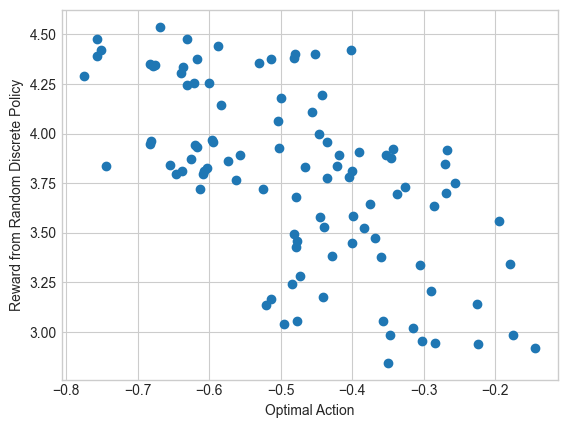

In [38]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

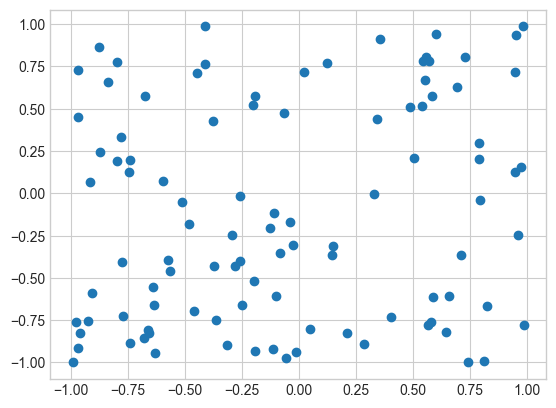

In [39]:
plt.scatter(obs_arr[:,0], obs_arr[:, 1])

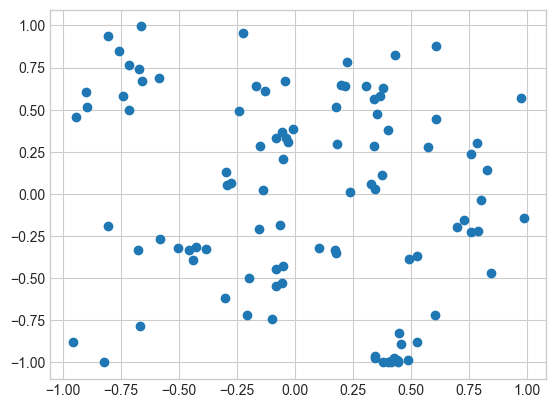

In [40]:
agent_buffer = np.array(ppo_agent.context_buffer)

plt.scatter(agent_buffer[:,0], agent_buffer[:, 1])

In [41]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 3125)


In [42]:
print(df_hist)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


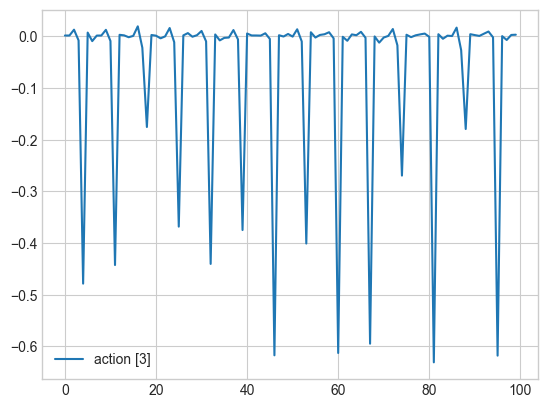

In [43]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

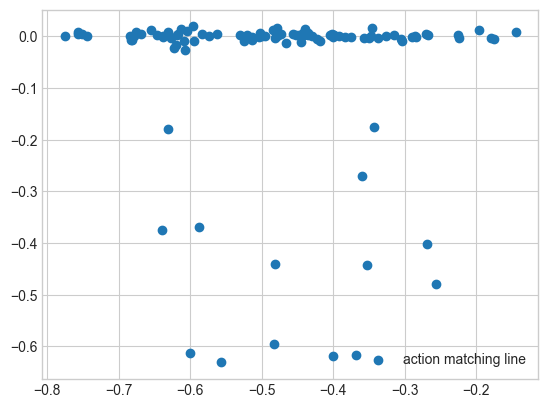

In [44]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [55]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=2,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [56]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.25
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [57]:
o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles

In [58]:
ana_sum = -np.sum(o_vals, axis=1) * 0.015
ana_sum

array([-0.        , -0.01178097, -0.02356194, ..., -0.2120575 ,
       -0.22383848, -0.23561945])

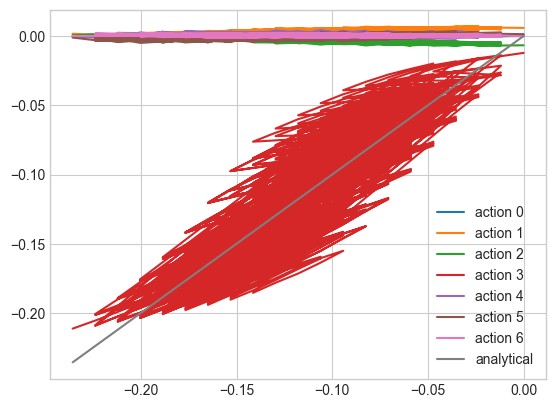

In [59]:
actions = np.array(actions)

for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [60]:
import torch

# random_obs = np.random.choice(ppo_agent.env.unwrapped.discrete_obs_vals, size=1000, replace=True)
random_obs = np.random.uniform(0., np.pi, (1000, 5))
print(random_obs)

[[0.9286326  1.91793799 0.89511114 1.9374896  1.29411316]
 [0.02443295 1.06311776 0.82611699 1.68407084 1.33666419]
 [2.71136828 1.14533025 3.04317269 1.81814773 1.04877819]
 ...
 [0.11452471 2.75161708 0.79421141 3.12192324 0.44341763]
 [2.31340745 0.62971926 0.97242944 3.04667918 1.5563283 ]
 [2.62947417 3.05385021 0.33021498 0.91245799 0.34387255]]


In [61]:
full_reward = []

for sample_obs in random_obs:
    _obs, info = single_n_q_env.reset(debug_obs=np.array([sample_obs]))
    next_obs = torch.Tensor(np.tile(_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.25

    cpu_action = np.mean(cpu_action, axis=0).reshape(1, -1)
    # cpu_action = np.tile(cpu_action, (2, 1))
    total_action = np.concatenate(
        (cpu_action, np.zeros((1, 7))), axis=0
    )
    # total_action = cpu_action
    print(total_action.shape)

    obs, reward, terminated, truncated, info = single_n_q_env.step(total_action)
    full_reward.append(reward)

Sampled angles:  [0.9286326  1.91793799 0.89511114 0.         1.9374896  1.29411316]
Environment Observation: [[-0.40881413  0.22099725 -0.43015455  0.23344419 -0.17614198]]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.998843695619797
Reward (avg): 0.998843695619797 Std: 0.0011560992126034009
obs: [[-0.40881413  0.22099725 -0.43015455  0.23344419 -0.17614198]]
reward: [6.         2.63593636]
Sampled angles:  [0.02443295 1.06311776 0.82611699 0.         1.68407084 1.33666419]
Environment Observation: [[-0.9844455  -0.32319821 -0.47407759  0.07211279 -0.14905315]]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9992454330082947
Reward (avg): 0.9992454330082947 Std: 0.0007539259136504217
obs: [[-0.9844455  -0.32319821 -0.47407759  0.07211279 -0.14905315]]
reward: [6.         2.82145673]
Sampled angles:  [2.71136828 1.14533

In [74]:
full_reward_arr = np.array(full_reward)

policy_reward = full_reward_arr[:,0]
baseline_reward = full_reward_arr[:,1]

In [75]:
policy_reward

array([6.        , 6.        , 6.        , 5.94257326, 5.82523548,
       6.        , 5.79289049, 5.58022667, 5.36589173, 5.71943935,
       5.74082852, 5.64615322, 5.40889868, 6.        , 5.66366065,
       5.88259239, 5.84879114, 5.81526428, 5.44089735, 5.39315316,
       6.        , 6.        , 6.        , 6.        , 5.75903902,
       5.92405769, 5.51159892, 5.13302617, 6.        , 5.89722363,
       5.57454011, 6.        , 5.55286377, 5.92828724, 5.37133438,
       6.        , 4.72797544, 5.89501032, 5.97579302, 5.2725264 ,
       5.56741205, 5.8571596 , 5.98996314, 5.99272309, 6.        ,
       5.28616311, 5.6652581 , 5.59648776, 6.        , 5.68642484,
       5.77321187, 5.60203926, 5.83550494, 5.00165524, 4.95822386,
       5.68981247, 5.66505689, 5.37843643, 6.        , 5.35419603,
       6.        , 6.        , 6.        , 5.4121598 , 6.        ,
       4.98903353, 5.68211677, 6.        , 5.38931852, 5.5145496 ,
       5.5717817 , 5.33582085, 5.474941  , 6.        , 5.21383

In [76]:
print(len(policy_reward))

1000


In [77]:
print(len(baseline_reward))

1000


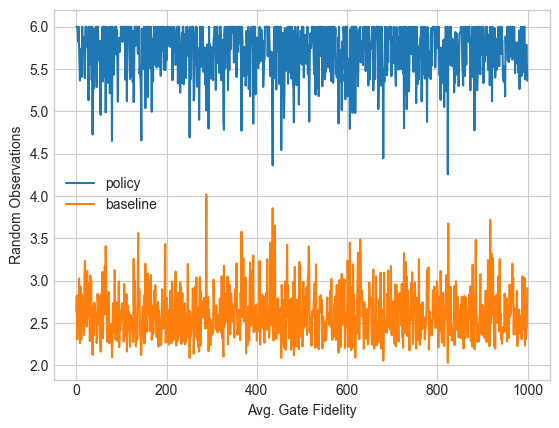

In [78]:
plt.plot(policy_reward, label='policy')
plt.plot(baseline_reward, label='baseline')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Random Observations')
plt.legend()
plt.show()

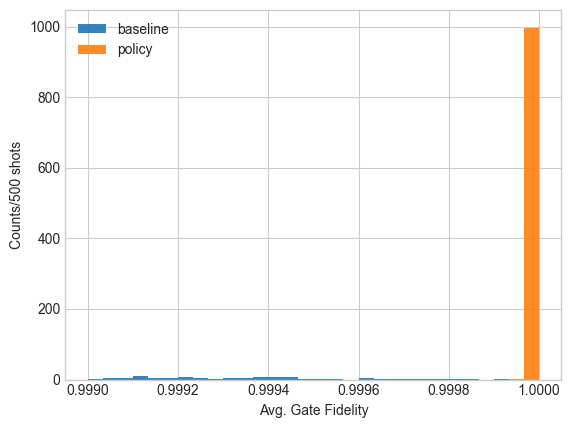

In [79]:
policy_fidelity = 1 - 10**(-np.array(policy_reward))
baseline_fidelity = 1 - 10**(-np.array(baseline_reward))
# baseline_fidelity = np.clip(baseline_fidelity, a_max=1 - 1e-5, a_min=None)

bins = np.linspace(0.999, 1, 31)  # 30 bins from 0 to 1
alpha = 0.9
plt.hist(baseline_fidelity, label='baseline', bins=bins, alpha=alpha)
plt.hist(policy_fidelity, label='policy', bins=bins, alpha=alpha)
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Counts/500 shots')
plt.legend()
plt.show()

In [80]:
import pandas as pd
import seaborn as sns

In [68]:
df = pd.DataFrame({
    "policy": policy_fidelity,
    "baseline": baseline_fidelity
})

df.to_csv('saved_results/fig_results')

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/501668435.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x='Policy', y='Infidelity', palette=['skyblue', 'lightgreen'])


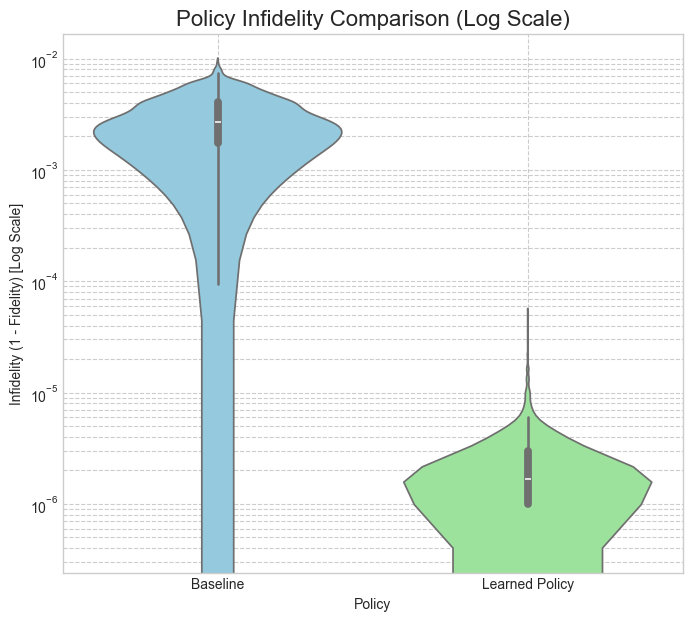

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Create sample data that mimics your situation ---
# Baseline has lower mean and higher variance
# baseline_fidelity = np.random.normal(loc=0.7, scale=0.2, size=1000)
# baseline_fidelity = np.clip(baseline_fidelity, 0.1, 1.0)

# Learned policy is extremely good with very low variance
# We use a log-normal distribution to generate very small errors
# policy_errors = np.random.lognormal(mean=-10, sigma=1.5, size=1000)
# policy_fidelity = 1.0 - policy_errors
# policy_fidelity = np.clip(policy_fidelity, 0.0, 1.0)

# 1. Calculate Infidelity (1 - Fidelity)
max_fidelity = 1.0
baseline_infidelity = max_fidelity - baseline_fidelity
policy_infidelity = max_fidelity - policy_fidelity

# Prevent log(0) errors by clipping to a very small number
policy_infidelity = np.clip(policy_infidelity, 1e-9, None)

# 2. Create a DataFrame for Seaborn
data = pd.DataFrame({
    'Infidelity': np.concatenate([baseline_infidelity, policy_infidelity]),
    'Policy': ['Baseline'] * 1000 + ['Learned Policy'] * 1000
})

# 3. Create the plot
plt.figure(figsize=(8, 7))
ax = sns.violinplot(data=data, x='Policy', y='Infidelity', palette=['skyblue', 'lightgreen'])

# 4. Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

plt.ylabel('Infidelity (1 - Fidelity) [Log Scale]')
plt.title('Policy Infidelity Comparison (Log Scale)', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.show()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/1649966246.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, palette=['skyblue', 'lightgreen'], inner=None, cut=0)
/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/1649966246.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, width=0.1,


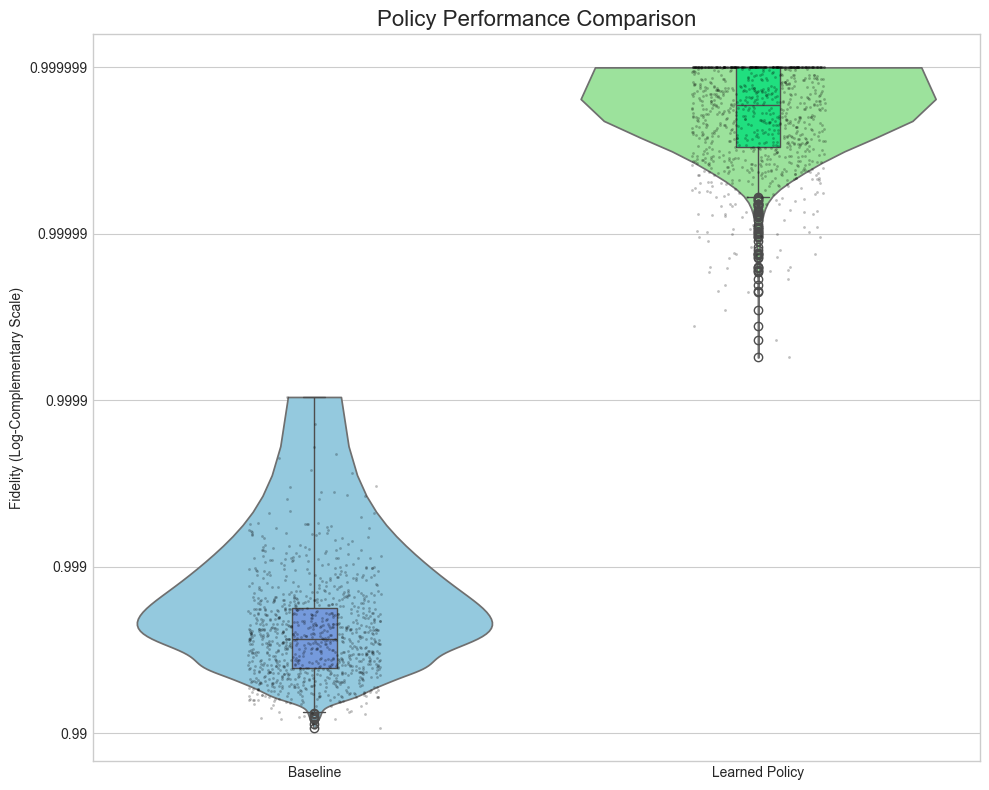

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter

# # --- Create sample data that mimics your situation ---
# # Baseline has lower mean and higher variance
# baseline_fidelity = np.random.normal(loc=0.8, scale=0.15, size=1000)
# baseline_fidelity = np.clip(baseline_fidelity, 0.5, 1.0)

# # Learned policy is extremely good with very low variance, near 1.0
# policy_errors = np.random.lognormal(mean=-11, sigma=1.0, size=1000)
# policy_fidelity = 1.0 - policy_errors
# policy_fidelity = np.clip(policy_fidelity, 0.0, 1.0)


# 1. Calculate Infidelity (1 - Fidelity)
# This is what we will actually plot on the y-axis.
max_fidelity = 1.0
baseline_infidelity = max_fidelity - baseline_fidelity
policy_infidelity = max_fidelity - policy_fidelity

# Prevent log(0) errors by clipping to a very small number
baseline_infidelity = np.clip(baseline_infidelity, 1e-9, None)
policy_infidelity = np.clip(policy_infidelity, 1e-9, None)


# 2. Create a DataFrame for Seaborn
data_to_plot = pd.DataFrame({
    'Infidelity': np.concatenate([baseline_infidelity, policy_infidelity]),
    'Policy': ['Baseline'] * 1000 + ['Learned Policy'] * 1000
})


# 3. Create the Raincloud Plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the main components on the 'Infidelity' data
sns.violinplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, palette=['skyblue', 'lightgreen'], inner=None, cut=0)
sns.stripplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, color='black', jitter=0.15, size=2.0, alpha=0.25)
sns.boxplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, width=0.1, 
            boxprops={'zorder': 2}, palette=['cornflowerblue', 'springgreen'])


# 4. Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

# 5. Invert the axis so high fidelity (low infidelity) is at the top
ax.invert_yaxis()

# 6. Apply custom formatting to the Y-axis labels
# This function takes the tick value (infidelity) and formats it as a fidelity
formatter = FuncFormatter(lambda y, _: f'{1-y:g}')
ax.yaxis.set_major_formatter(formatter)


# 7. Set final labels and title
ax.set_xlabel(None)
ax.set_ylabel('Fidelity (Log-Complementary Scale)')
ax.set_title('Policy Performance Comparison', fontsize=16)

plt.tight_layout()
plt.show()

In [88]:
data_to_plot.to_csv('saved_results/raincloud_plot_results_fid')

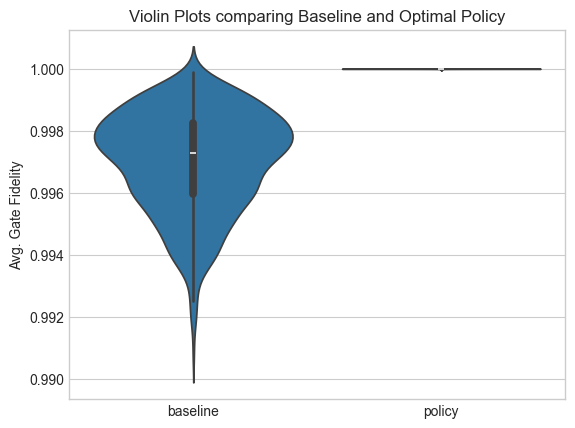

In [83]:
sns.violinplot(data=[baseline_fidelity, policy_fidelity], orient='v')
plt.xticks([0, 1], ['baseline', 'policy'])
plt.ylabel('Avg. Gate Fidelity')
plt.title('Violin Plots comparing Baseline and Optimal Policy')
plt.show()